# Introduction to AI/ML Applications for X-ray Experiments

## Background

This tutorial describes an introductory-level AI/ML application for powder X-ray diffraction analysis. We demonstrate an approach for developing an ML workflow in the following steps, using ChatGPT to aid the process:
1. Define a classification task
2. Organize simulated data and labels
3. Build a convolutional neural network 
4. Train the model
5. Analyze the model performance

## Getting started

### For Google Colaboratory only (skip these steps if running a local copy of the notebook):

1. (Optional) In order to save changes to this notebook, select "Copy to Drive" at the top. This will save a version of the notebook to your Google Drive

2. We'll also need access to the data files, provided in this Google Drive link: INSERT LINK HERE

3. Run the code block below to mount Google Drive in Colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Problem Statement

High-energy X-ray diffraction microscopy (HEDM) is a technique for strain-mapping of individual grains within a polycrystalline aggregate by taking diffraction patterns as a function of rotation angle. To learn more, check out this resource: https://www.aps.anl.gov/Sector-1/1-ID/Techniques. 

Illustration below from: Sharma, H., Huizenga, R. M. & Offerman, S. E. A fast methodology to determine the characteristics of thousands of grains using three-dimensional X-ray diffraction. II. Volume, centre-of-mass position, crystallographic orientation and strain state of grains. *J. Appl. Cryst.* **45**, 705-718 (2012).

![alt text](3DXRD_schematic.png "schematic")

## Use ChatGPT to gather some background information:

Prompt: I am working on powder X-ray diffraction. How do you distinguish diffraction by randomly oriented crystals from texture crystals?

Response: Distinguishing diffraction by randomly oriented crystals from textured crystals in powder X-ray diffraction (PXRD) involves analyzing the intensity distribution of the diffraction peaks. Here's how you can identify each scenario:

### Randomly Oriented Crystals
- **Uniform Intensity Distribution**: In a sample with randomly oriented crystals, the diffraction peaks appear with intensities that match those predicted by the crystal structure. The powder average ensures that all possible orientations contribute equally, leading to uniform intensity distribution for the corresponding crystallographic planes.
- **Smooth and Reproducible Patterns**: The diffraction pattern will be smooth and reproducible, given that all orientations are equally probable.

### Textured Crystals
- **Preferred Orientation (Texture)**: Textured crystals exhibit preferred orientation, meaning certain crystallographic planes are more likely to be aligned in a particular direction. This results in a non-uniform intensity distribution.
- **Anomalous Peak Intensities**: Peaks corresponding to the crystallographic planes that are preferentially oriented will show higher intensities than expected. Conversely, peaks from planes that are less favorably oriented will be weaker.
- **Azimuthal Dependence**: In texture analysis, a two-dimensional (2D) diffraction pattern (from area detectors) can show intensity variations as a function of the azimuthal angle, indicating preferred orientation.
- **Pole Figures**: Constructing pole figures can help visualize the preferred orientation. A pole figure plots the orientation of a particular crystallographic plane relative to the sample orientation and reveals texture.

### Practical Steps to Distinguish
1. **Compare with Reference Patterns**: Compare your PXRD pattern with the reference pattern for the randomly oriented powder. Significant deviations in peak intensities suggest preferred orientation.
2. **Use Rietveld Refinement**: Apply Rietveld refinement with a model that includes texture parameters. This helps quantify the degree of preferred orientation and refine the crystal structure accordingly.
3. **2D Diffraction Patterns**: If available, use 2D diffraction data to analyze the azimuthal variation in peak intensities. Rings with uniform intensity indicate random orientation, while intensity variations along the rings suggest texture.
4. **Pole Figures and Orientation Distribution Function (ODF)**: For a detailed analysis, construct pole figures and calculate the ODF. This provides a comprehensive picture of the crystallographic texture in the sample.

By following these steps, you can distinguish between diffraction patterns of randomly oriented crystals and those with preferred orientation, allowing for more accurate interpretation of your PXRD data.

# Load Data

The simulated data used in this tutorial is courtesy of Dr. Hemant Sharma (https://github.com/marinerhemant), Computational Scientist in the Computational Science and Artificial Intelligence (CAI) Group of the X-ray Science Division (XSD) at Argonne. He is the developer of the Microstructure Identification using Diffraction Analysis Software (MIDAS). 

In [57]:
"""# Install packages if necessary!
!pip install numpy
!pip install matplotlib
!pip install torch torchvision
!pip install pickle
!pip install opencv-python
"""

'# Install packages if necessary!\n!pip install numpy\n!pip install matplotlib\n!pip install torch torchvision\n!pip install pickle\n!pip install opencv-python\n'

In [1]:
import numpy as np

data = np.load('/gdrive/My Drive/NXSchool2024_MLDemo_Data/data.npy')
labels = np.load('/gdrive/My Drive/NXSchool2024_MLDemo_Data/labels.npy')

## Plot an example

First, let's compare ideal 2D diffraction patterns for an HEDM experiment. These are simulated with the full detector size and synchrotron scattering geometry. 
![alt text](Ideal.png "ideal")

The data used in this demonstration is a set of simulated diffraction patterns for a smaller detector size (256 x 256 pixels). Run the following code cells to plot some examples. 

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

Text(0.5, 1.0, 'Random grains')

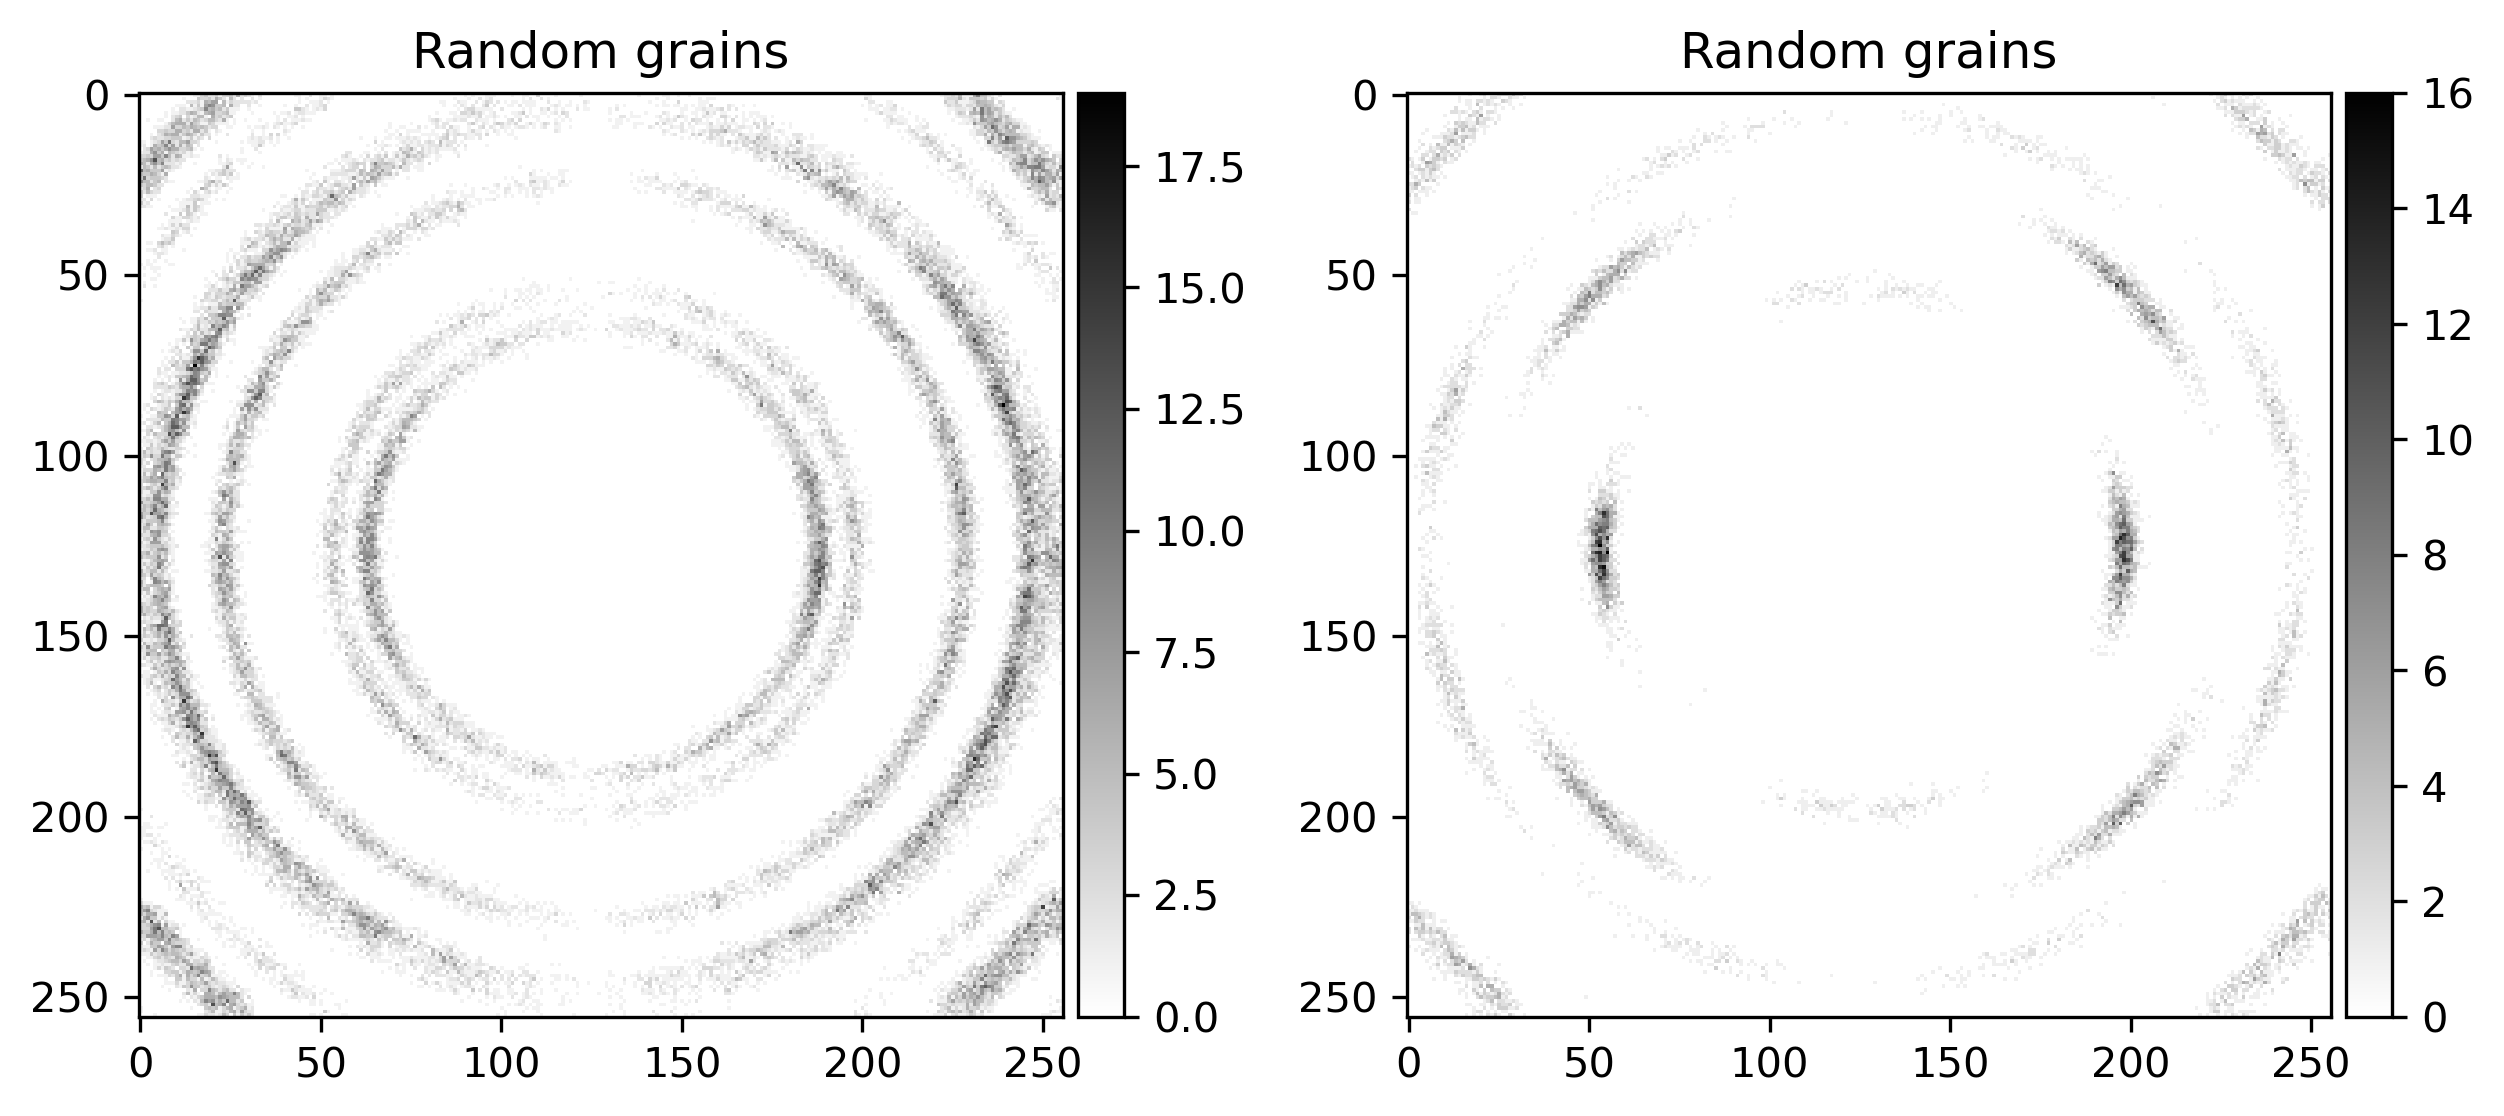

In [27]:
f, ax = plt.subplots(figsize=(10, 4), ncols=2, dpi=300)

im0 = ax[0].imshow(data[39], interpolation='none', cmap='gray_r')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='vertical')
ax[0].set_title('Random grains')

im1 = ax[1].imshow(data[199], interpolation='none', cmap='gray_r')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='vertical')
ax[1].set_title('Random grains')

We can apply some preliminary data pre-processing to further mimic experimental data. Notice that the images we plotted above have great signal-to-noise ratio. Experimental data, particularly those collected under dynamic conditions, often have fewer photon counts. Below, we scale the data to a maximum of 10 counts per image and apply Poisson noise. How do you think the diffraction intensity will affect the way the model trains? What happens if we scale to 1000, 100, or even 1 photon maximum per image?

In [4]:
# Scale to 10 counts
for i in range(data.shape[0]):
    data[i] = (data[i] / np.max(data[i])) * 10

# Apply Poisson noise
for i in range(data.shape[0]):
    data[i] = np.random.poisson(data[i])    

Text(0.5, 1.0, 'Textured grains')

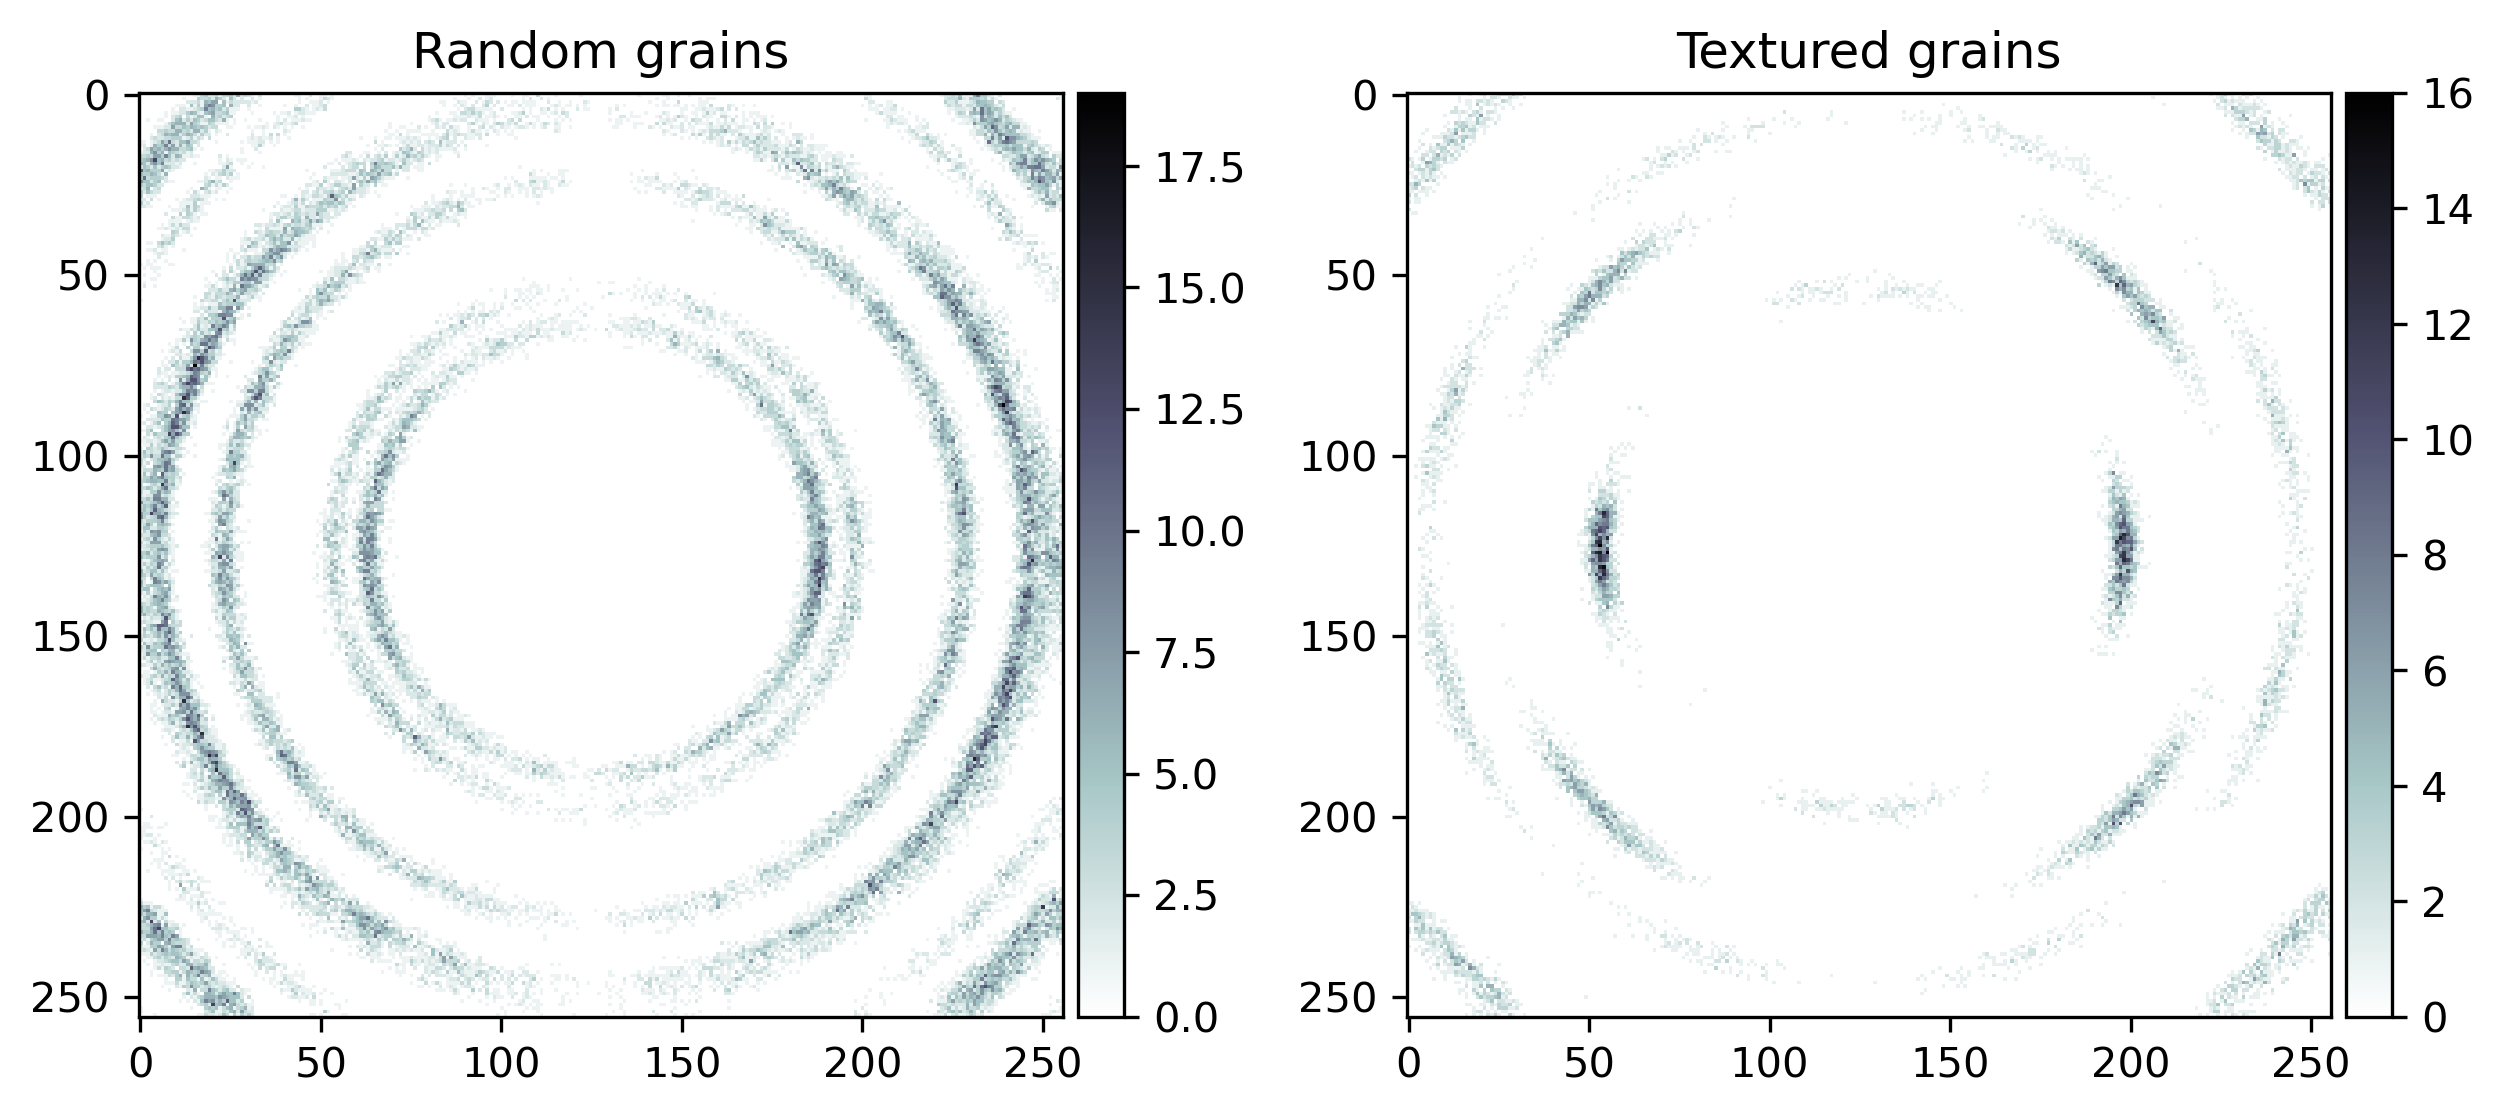

In [5]:
f, ax = plt.subplots(figsize=(10, 4), ncols=2, dpi=300)

im0 = ax[0].imshow(data[39], interpolation='none', cmap='gray_r')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='vertical')
ax[0].set_title('Random grains')

im1 = ax[1].imshow(data[199], interpolation='none', cmap='gray_r')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='vertical')
ax[1].set_title('Textured grains')

# Classification Workflow

ChatGPT prompt (I went through several iterations of asking for different modifications to suit this specific example): Write an example of a neural network for classification of powder X-ray diffraction patterns in PyTorch. I would like a binary classification of whether they are from randomly oriented or textured powder samples. 

Response (only the summary portion): 
### Summary

1. **Custom Dataset**: Handles loading images and labels from NumPy arrays and applies transformations.
2. **Data Splitting**: Splits the dataset into training and validation sets.
3. **DataLoaders**: Wraps the datasets into DataLoaders.
4. **CNN Definition**: Defines a CNN for binary classification.
5. **Training Loop**: Trains the model and validates it, saving the trained model at the end.

## Make PyTorch Dataset

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class PXRDDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (numpy array): Array of images.
            labels (numpy array): Array of labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
            
        label = torch.tensor(label, dtype=torch.long)

        return image, label

class ToTensor(object):
    """Convert numpy arrays to Tensors (different from the default transforms.ToTensor() method to
    account for our data format)"""
    def __call__(self, image):
        return torch.unsqueeze(torch.from_numpy(image), 0)

In [7]:
dataset = PXRDDataset(images=data, labels=labels, transform=ToTensor())

## Split into Training and Validation Sets

In [8]:
# Define the split ratio
train_ratio = 0.25 # Adjust this and see how it affects training!
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## Put the Datasets in DataLoaders

In [9]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}

## Define a CNN for Classification

ChatGPT prompt: What is a CNN? Explain each component of a typical CNN in one bullet point.

Response: A Convolutional Neural Network (CNN) is a type of deep learning model particularly well-suited for analyzing visual data. Here are the components of a typical CNN, each explained in one bullet point:

1. **Input Layer**:
   - Receives the input image as a multi-dimensional array (tensor), where the dimensions typically represent height, width, and color channels (e.g., RGB).


2. **Convolutional Layer (Conv Layer)**:
   - Applies a set of learnable filters (kernels) to the input image to detect various features such as edges, textures, and patterns by convolving the filters with the input.
![alt text](convolution.gif "conv2d")
Animation: https://hannibunny.github.io/mlbook/neuralnetworks/convolutionDemos.html


3. **Activation Function (e.g., ReLU)**:
   - Introduces non-linearity into the model by applying a function like ReLU (Rectified Linear Unit), which replaces all negative pixel values in the feature map by zero to enhance the model's ability to learn complex patterns.


4. **Pooling Layer (e.g., Max Pooling)**:
   - Reduces the spatial dimensions (height and width) of the feature maps, typically using operations like max pooling, to down-sample the representation and reduce computational complexity while retaining important information.


5. **Fully Connected Layer (Dense Layer)**:
   - Flattens the feature maps into a single vector and connects every neuron in this vector to neurons in the next layer, allowing the network to make final classifications or predictions based on the extracted features.


6. **Output Layer**:
   - Produces the final prediction, which can be a single value or a vector of values, depending on the task (e.g., a single class label for classification or multiple values for object detection).


7. **Loss Function**:
   - Measures the difference between the predicted output and the actual target values, guiding the optimization process to minimize this error during training.


8. **Optimizer**:
   - Adjusts the weights of the network based on the gradients computed during backpropagation to minimize the loss function, examples include SGD (Stochastic Gradient Descent) and Adam.


9. **Backpropagation**:
   - A training algorithm that updates the weights in the network by calculating the gradient of the loss function with respect to each weight and propagating these gradients backward through the network.
   
   

In [10]:
import torch.nn as nn
import torch.optim as optim

class PXRDNet(nn.Module):
    def __init__(self):
        super(PXRDNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize the network, loss function, and optimizer
model = PXRDNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

### Cross Entropy Loss 

ChatGPT prompt: Summarize Cross Entropy Loss in 2 sentences plus a formula.

Cross Entropy Loss measures the dissimilarity between the true labels and predicted probabilities, penalizing incorrect predictions more heavily. It is commonly used in classification tasks to optimize the performance of the model by minimizing the loss during training.

For a multi-class classification task, the loss for a single instance is given by:
$$ L = - \sum_{i=1}^C y_i \log(p_i) $$
where $ C $ is the number of classes, $ y_i $ is the binary indicator (0 or 1) if class $ i $ is the correct class, and $ p_i $ is the predicted probability for class $ i $.

## Train the Model

In [11]:
# Initialize dictionary to log losses and accuracies
metrics = {'train': [], 'val': [], 'train_acc': [], 'val_acc': []}

# Training Loop with Logging and Model Saving
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            metrics[phase].append(epoch_loss)
            if phase == 'train':
                metrics['train_acc'].append(epoch_acc.detach().cpu().numpy())
            else:
                metrics['val_acc'].append(epoch_acc.detach().cpu().numpy())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Save model after the first epoch
        if epoch == 0:
            torch.save(model.state_dict(), '/gdrive/My Drive/NXSchool2024_MLDemo_Data/pxrd_net_epoch_0.pth')

        print()

    # Save the final model
    torch.save(model.state_dict(), '/gdrive/My Drive/NXSchool2024_MLDemo_Data/pxrd_net_final.pth')

    return model

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Train and validate the model
model = train_model(model, criterion, optimizer, num_epochs=10)

cuda:0
Epoch 0/9
----------
train Loss: 0.6755 Acc: 0.5400
val Loss: 0.5785 Acc: 0.9000

Epoch 1/9
----------
train Loss: 0.5618 Acc: 0.8900
val Loss: 0.4966 Acc: 0.8967

Epoch 2/9
----------
train Loss: 0.4725 Acc: 0.9500
val Loss: 0.4152 Acc: 1.0000

Epoch 3/9
----------
train Loss: 0.3894 Acc: 1.0000
val Loss: 0.3486 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.3291 Acc: 1.0000
val Loss: 0.2869 Acc: 1.0000

Epoch 5/9
----------
train Loss: 0.2580 Acc: 1.0000
val Loss: 0.2394 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.2278 Acc: 1.0000
val Loss: 0.2026 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.1922 Acc: 1.0000
val Loss: 0.1662 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.1496 Acc: 1.0000
val Loss: 0.1433 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.1340 Acc: 1.0000
val Loss: 0.1208 Acc: 1.0000



In [12]:
import pickle

# Save losses to a pickle file
with open('/gdrive/My Drive/NXSchool2024_MLDemo_Data/metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

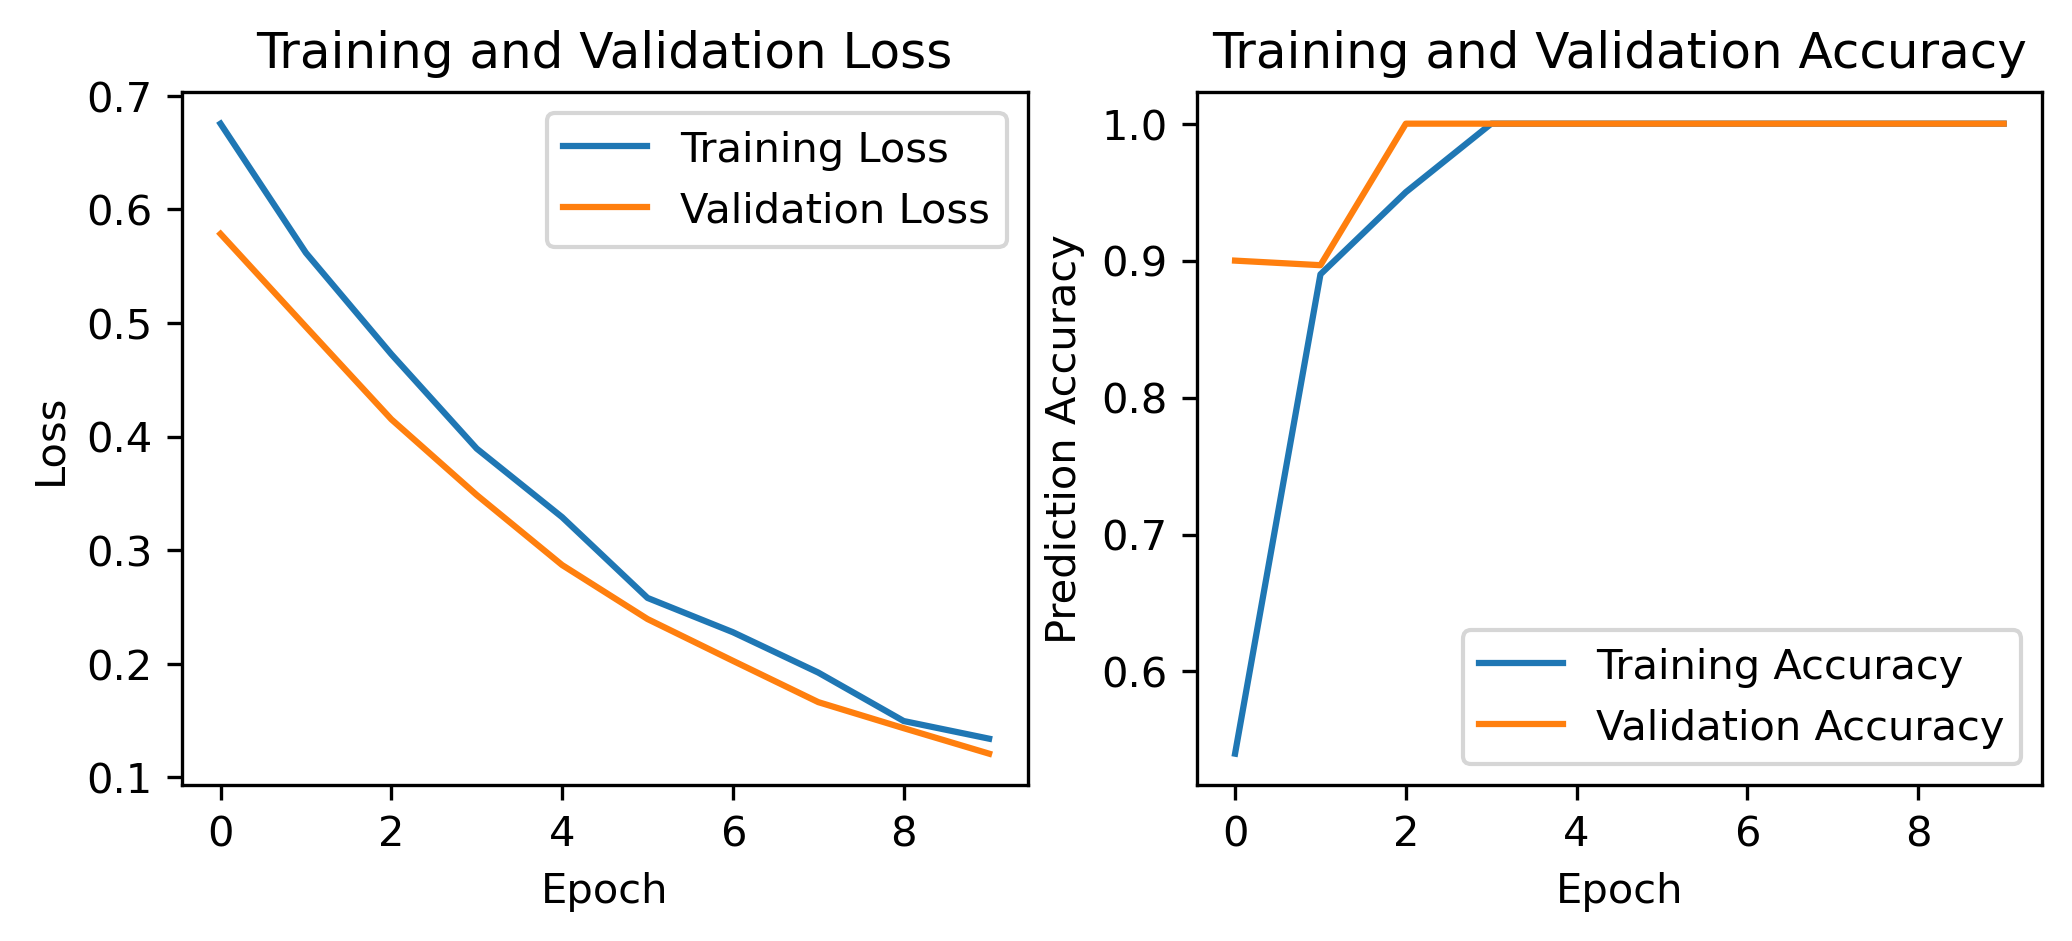

In [13]:
# Plot loss and accuracy curves
f, ax = plt.subplots(figsize=(8, 3), ncols=2, dpi=300)

ax[0].plot(metrics['train'], label='Training Loss')
ax[0].plot(metrics['val'], label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()

ax[1].plot(metrics['train_acc'], label='Training Accuracy')
ax[1].plot(metrics['val_acc'], label='Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Prediction Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()

# Grad-CAM

ChatGPT prompt: How do you get an attention map for a CNN?

Response (truncated for brevity): Attention maps for CNNs can be generated using techniques that highlight the regions of the input image which are most influential in making a prediction. Here are some common methods:

### 1. **Grad-CAM (Gradient-weighted Class Activation Mapping)**
Grad-CAM uses the gradients of any target concept, flowing into the final convolutional layer, to produce a coarse localization map highlighting important regions in the image.

**Steps to Generate a Grad-CAM:**
1. **Forward Pass**: Pass the input image through the CNN to obtain the output and the feature maps from the final convolutional layer.
2. **Compute Gradients**: Calculate the gradients of the target class with respect to the feature maps.
3. **Global Average Pooling**: Perform global average pooling on these gradients to obtain the weights.
4. **Weighted Sum**: Compute a weighted sum of the feature maps using the weights obtained.
5. **ReLU Activation**: Apply a ReLU activation to the resulting weighted sum to generate the attention map.

Grad-CAM is widely used and can be applied to any CNN architecture, making it a versatile choice for generating attention maps.

Prompt: Integrate the Grad-CAM for a random image in every eopch of training.

Response: Integrating Grad-CAM into every epoch of training allows you to visualize which parts of the image the model focuses on as it learns. Here is the modified training loop that includes Grad-CAM visualization for a random image at the end of each epoch:

### Step-by-Step Code Integration

1. **Training Loop**: Include the Grad-CAM generation and visualization within the training loop.
2. **Grad-CAM Function**: Define a function to generate and visualize Grad-CAM.
3. **Training and Visualization**: Update the training loop to call the Grad-CAM function at the end of each epoch.


In [40]:
import cv2

# Step 1: Define the Grad-CAM Function

def generate_and_plot_gradcam(model, input_image, target_class):
    model.eval()  # Ensure the model is in evaluation mode
    input_image.requires_grad_()
    
    # Register hooks for gradients and activations
    gradients = []
    global activations
    
    def save_gradient(grad):
        gradients.append(grad)
    
    def forward_hook(module, input, output):
        global activations
        activations = output.requires_grad_(True)
        output.register_hook(save_gradient)
    
    final_conv_layer = model.conv3
    final_conv_layer.register_forward_hook(forward_hook)
    
    input_image = input_image.to(device)
    
    # Forward pass
    output = model(input_image)
    
    # Compute the gradients of the output with respect to the target class
    model.zero_grad()
    output[0, target_class].backward()
    
    # Get the gradients and activations
    grads_val = gradients[0].cpu().data.numpy()
    activations = activations.cpu().data.numpy()
    
    # Global average pooling of the gradients
    weights = np.mean(grads_val, axis=(2, 3))[0, :]
    
    # Compute the weighted sum of the activations
    cam = np.zeros(activations.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activations[0, i, :, :]
    
    # Apply ReLU
    cam = np.maximum(cam, 0)
    
    # Normalize and resize the CAM
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (256, 256))
    
    # Overlay the CAM on the original image
    original_img = input_image.cpu().data.numpy()[0, 0]
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for overlay
    superimposed_img = heatmap * 0.4 + original_img
    #superimposed_img = cam + original_img
    
    # Display the result
    f, ax = plt.subplots(figsize=(10, 5), ncols=2, dpi=300)
    
    im0 = ax[0].imshow(original_img, interpolation='none', cmap='gray_r')
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im0, cax=cax, orientation='vertical')
    ax[0].set_title('Original Image')
    
    im1 = ax[1].imshow(superimposed_img, interpolation='none', cmap='gray_r')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im1, cax=cax, orientation='vertical')
    ax[1].set_title('Grad-CAM')
    plt.show()

Epoch 0/9
----------
train Loss: 0.6696 Acc: 0.7500
val Loss: 0.6458 Acc: 0.9700


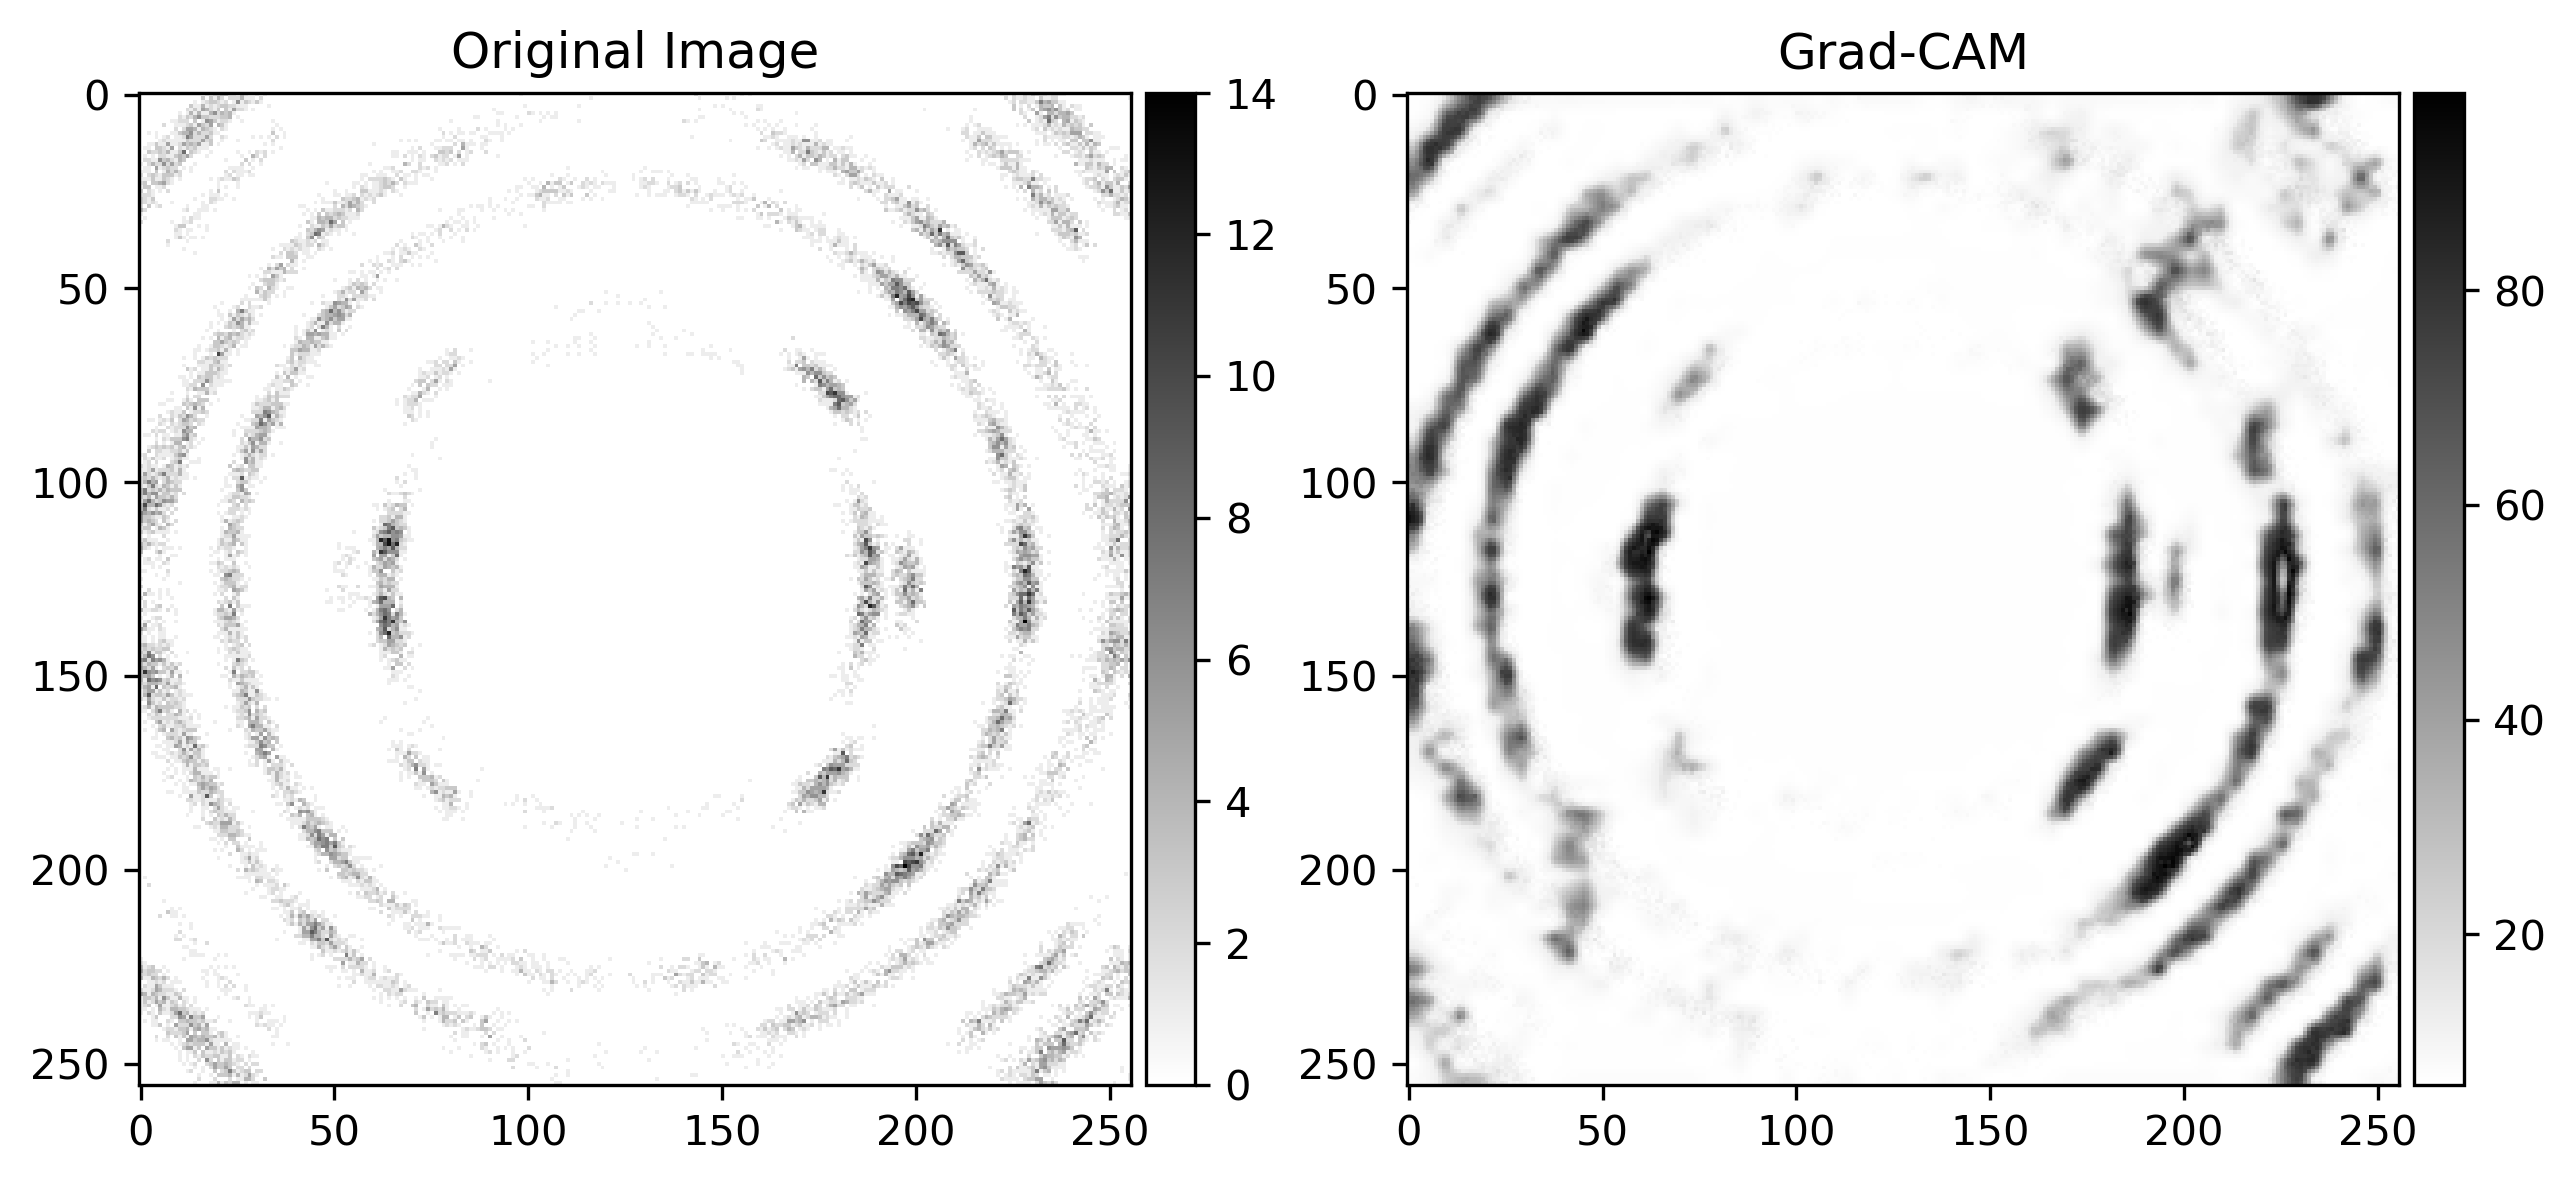


Epoch 1/9
----------
train Loss: 0.6382 Acc: 0.8700
val Loss: 0.6096 Acc: 0.9533


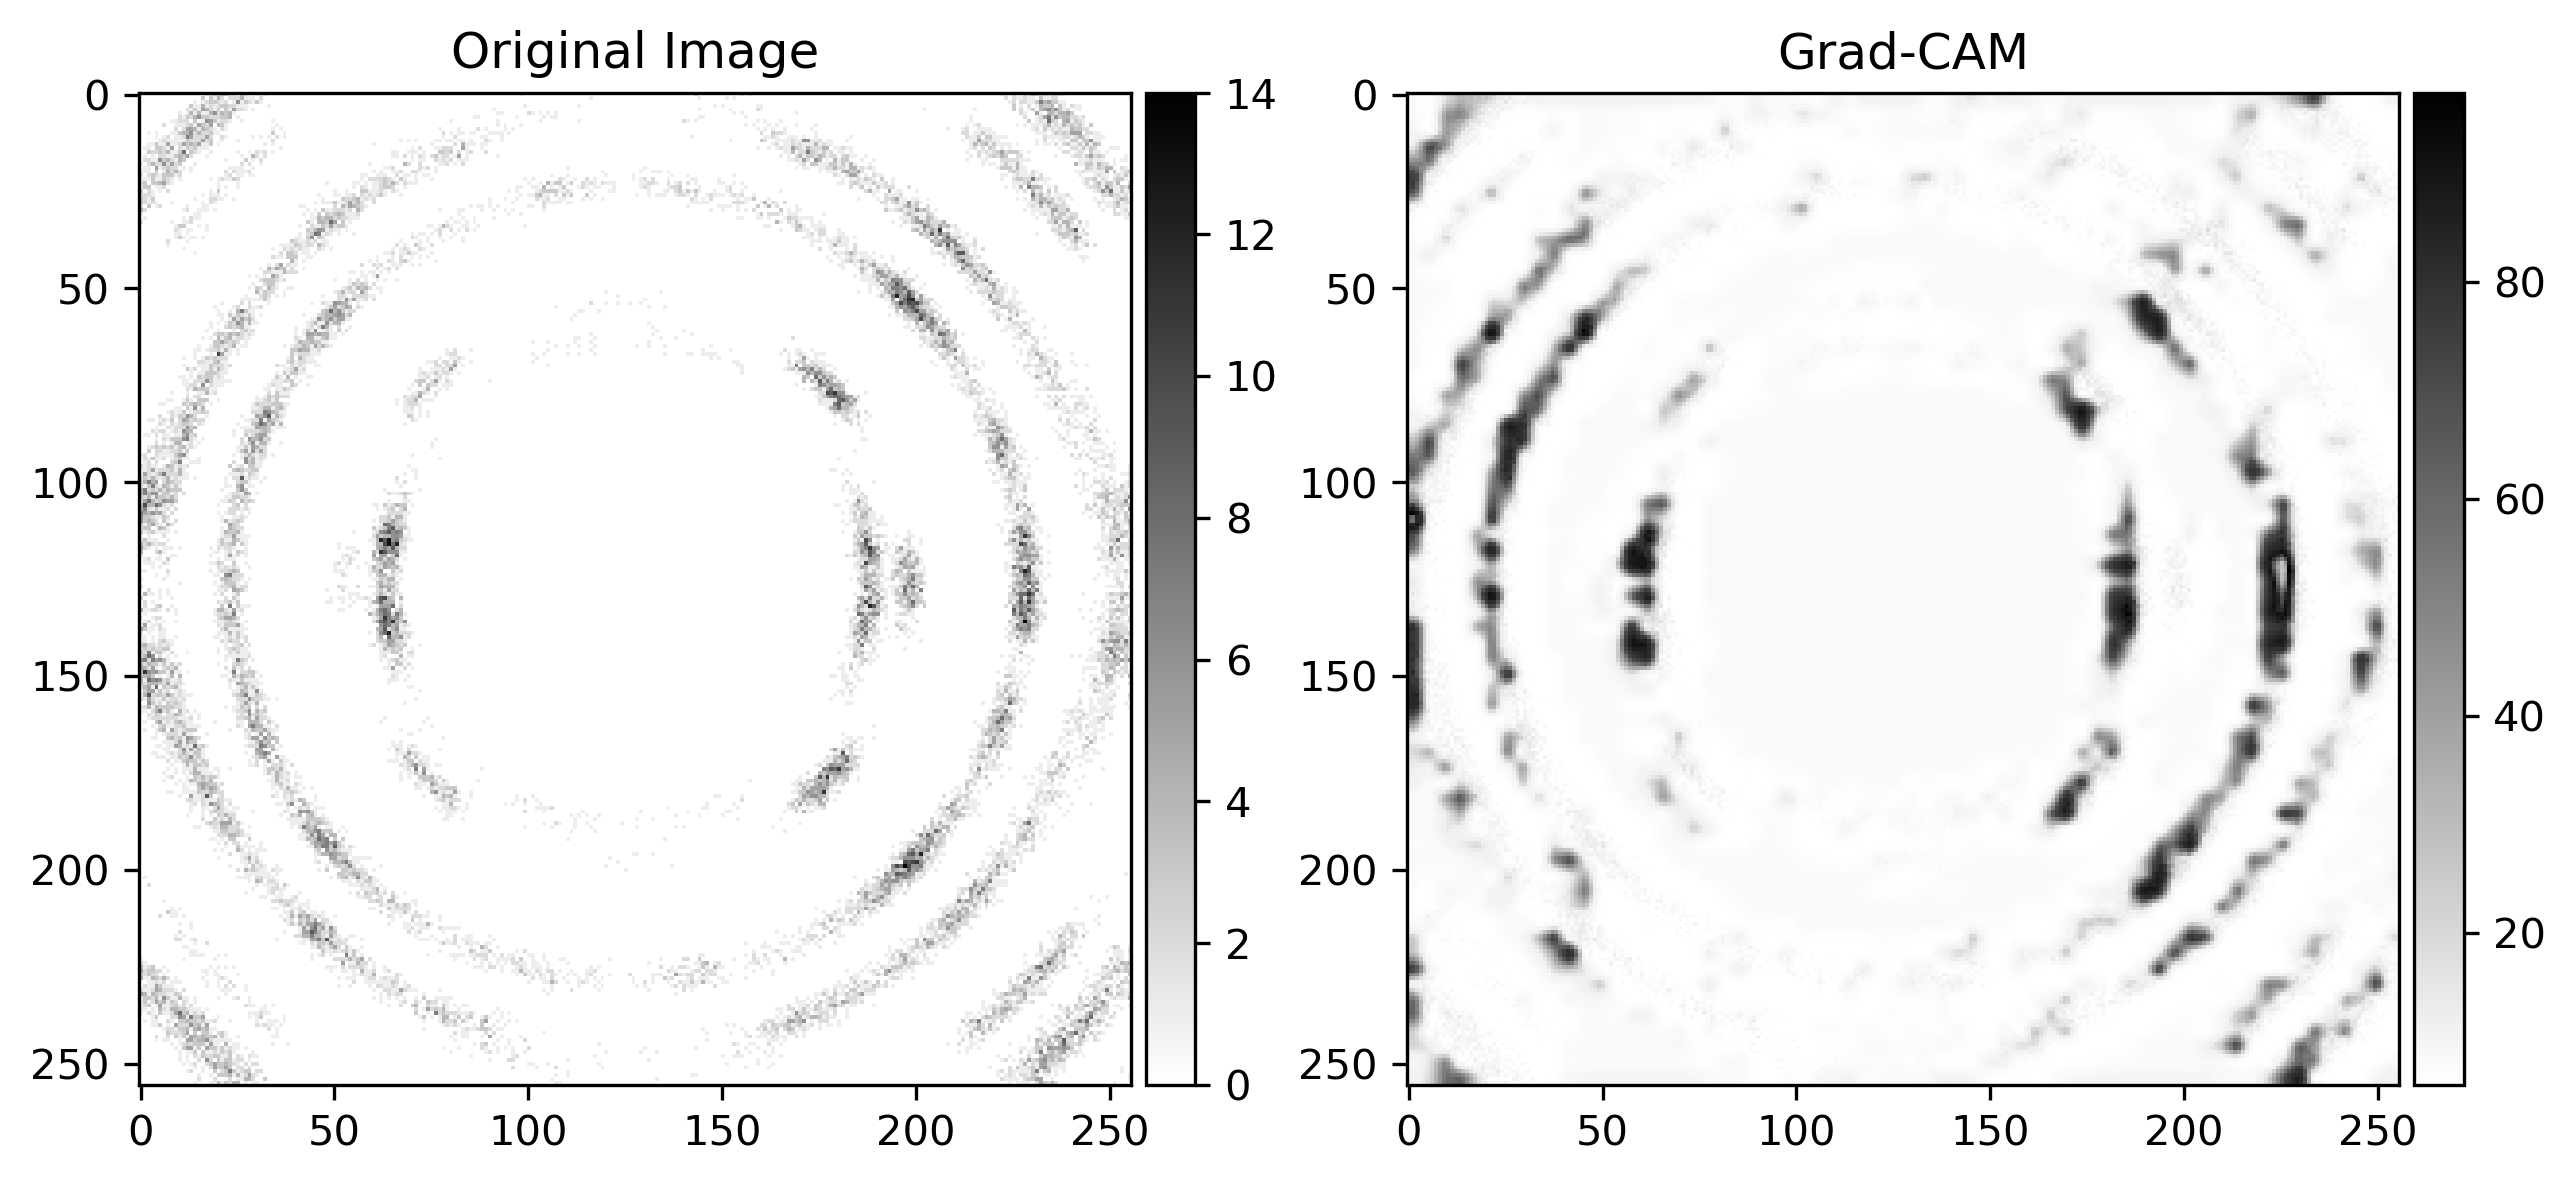


Epoch 2/9
----------
train Loss: 0.5946 Acc: 0.9300
val Loss: 0.5804 Acc: 0.9500


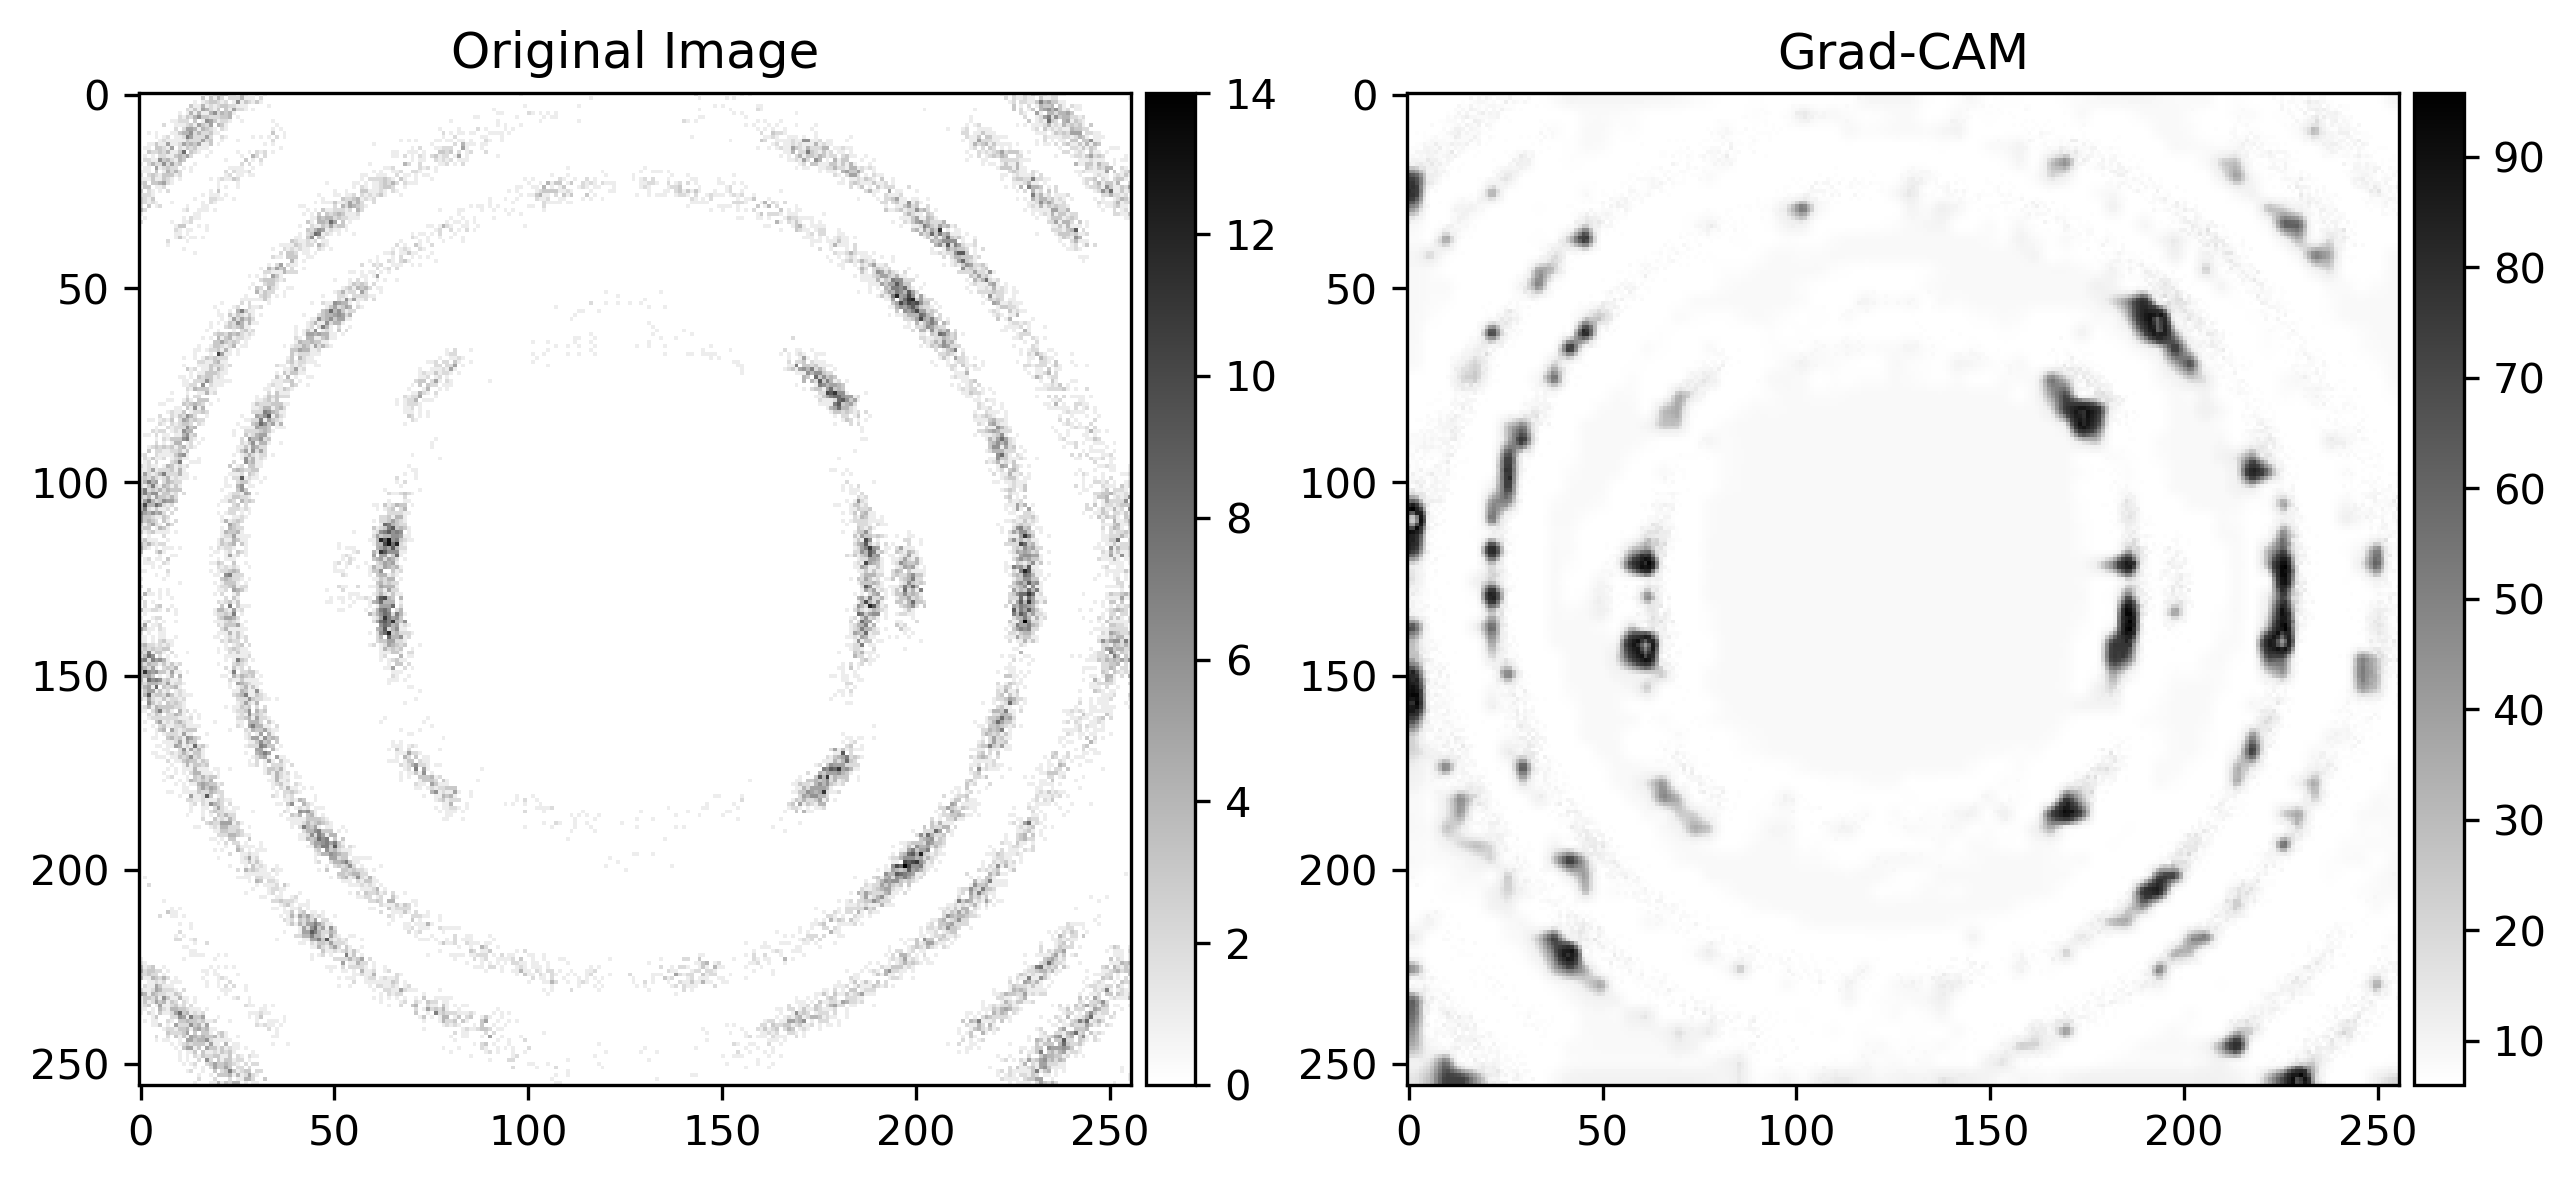


Epoch 3/9
----------
train Loss: 0.5771 Acc: 0.8700
val Loss: 0.5561 Acc: 0.9633


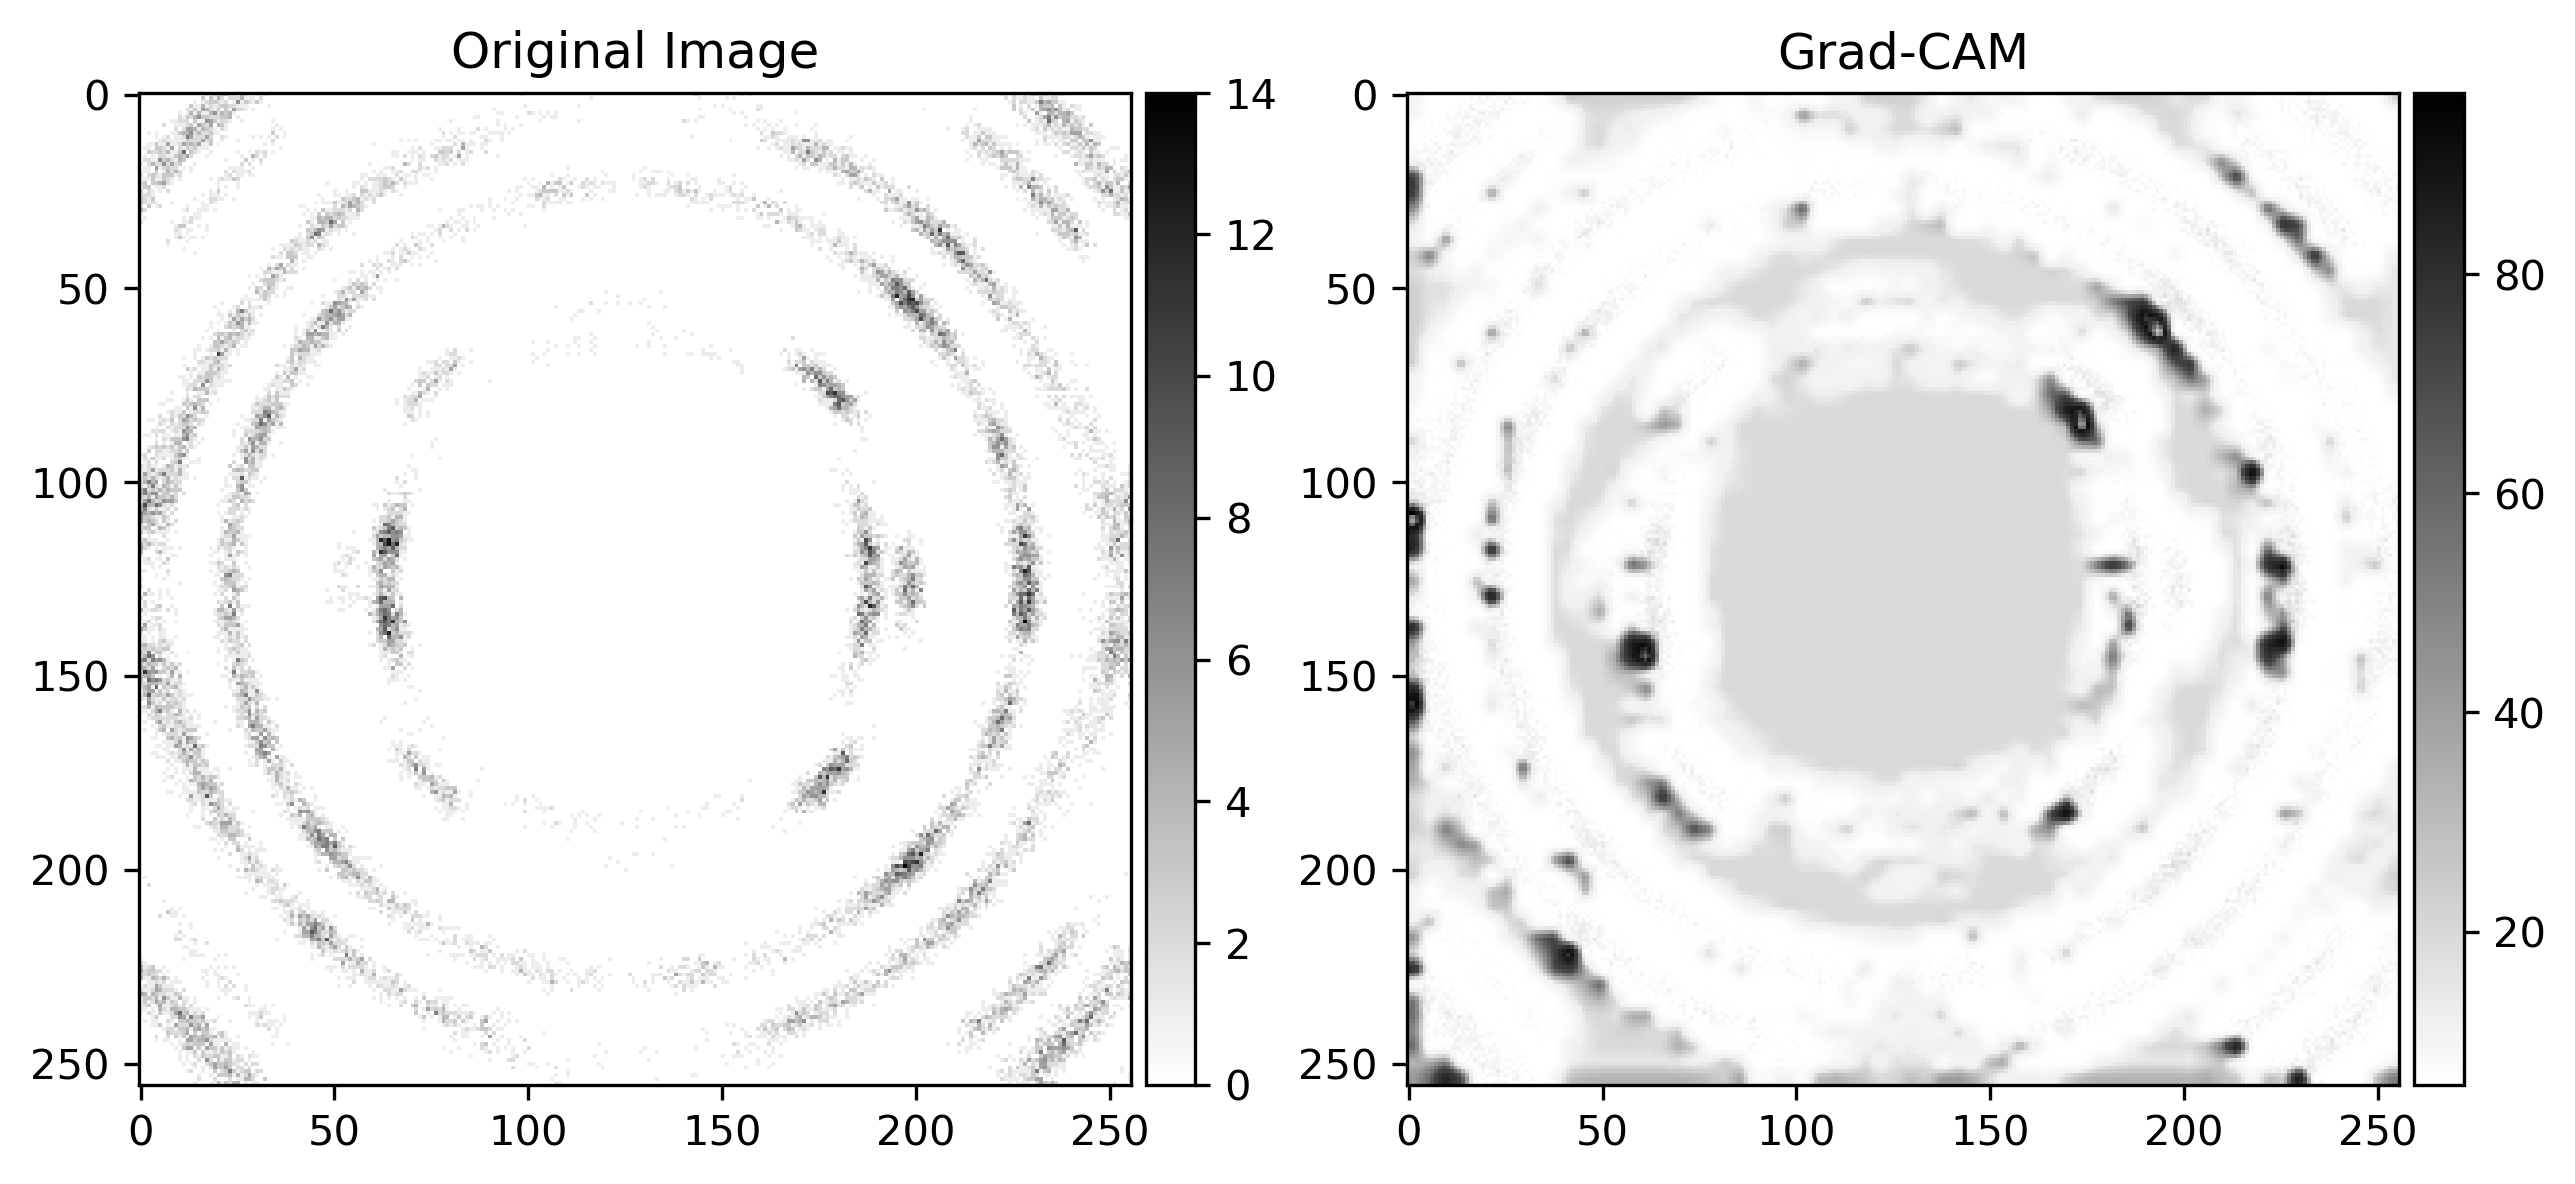


Epoch 4/9
----------
train Loss: 0.5397 Acc: 0.9600
val Loss: 0.5331 Acc: 0.9733


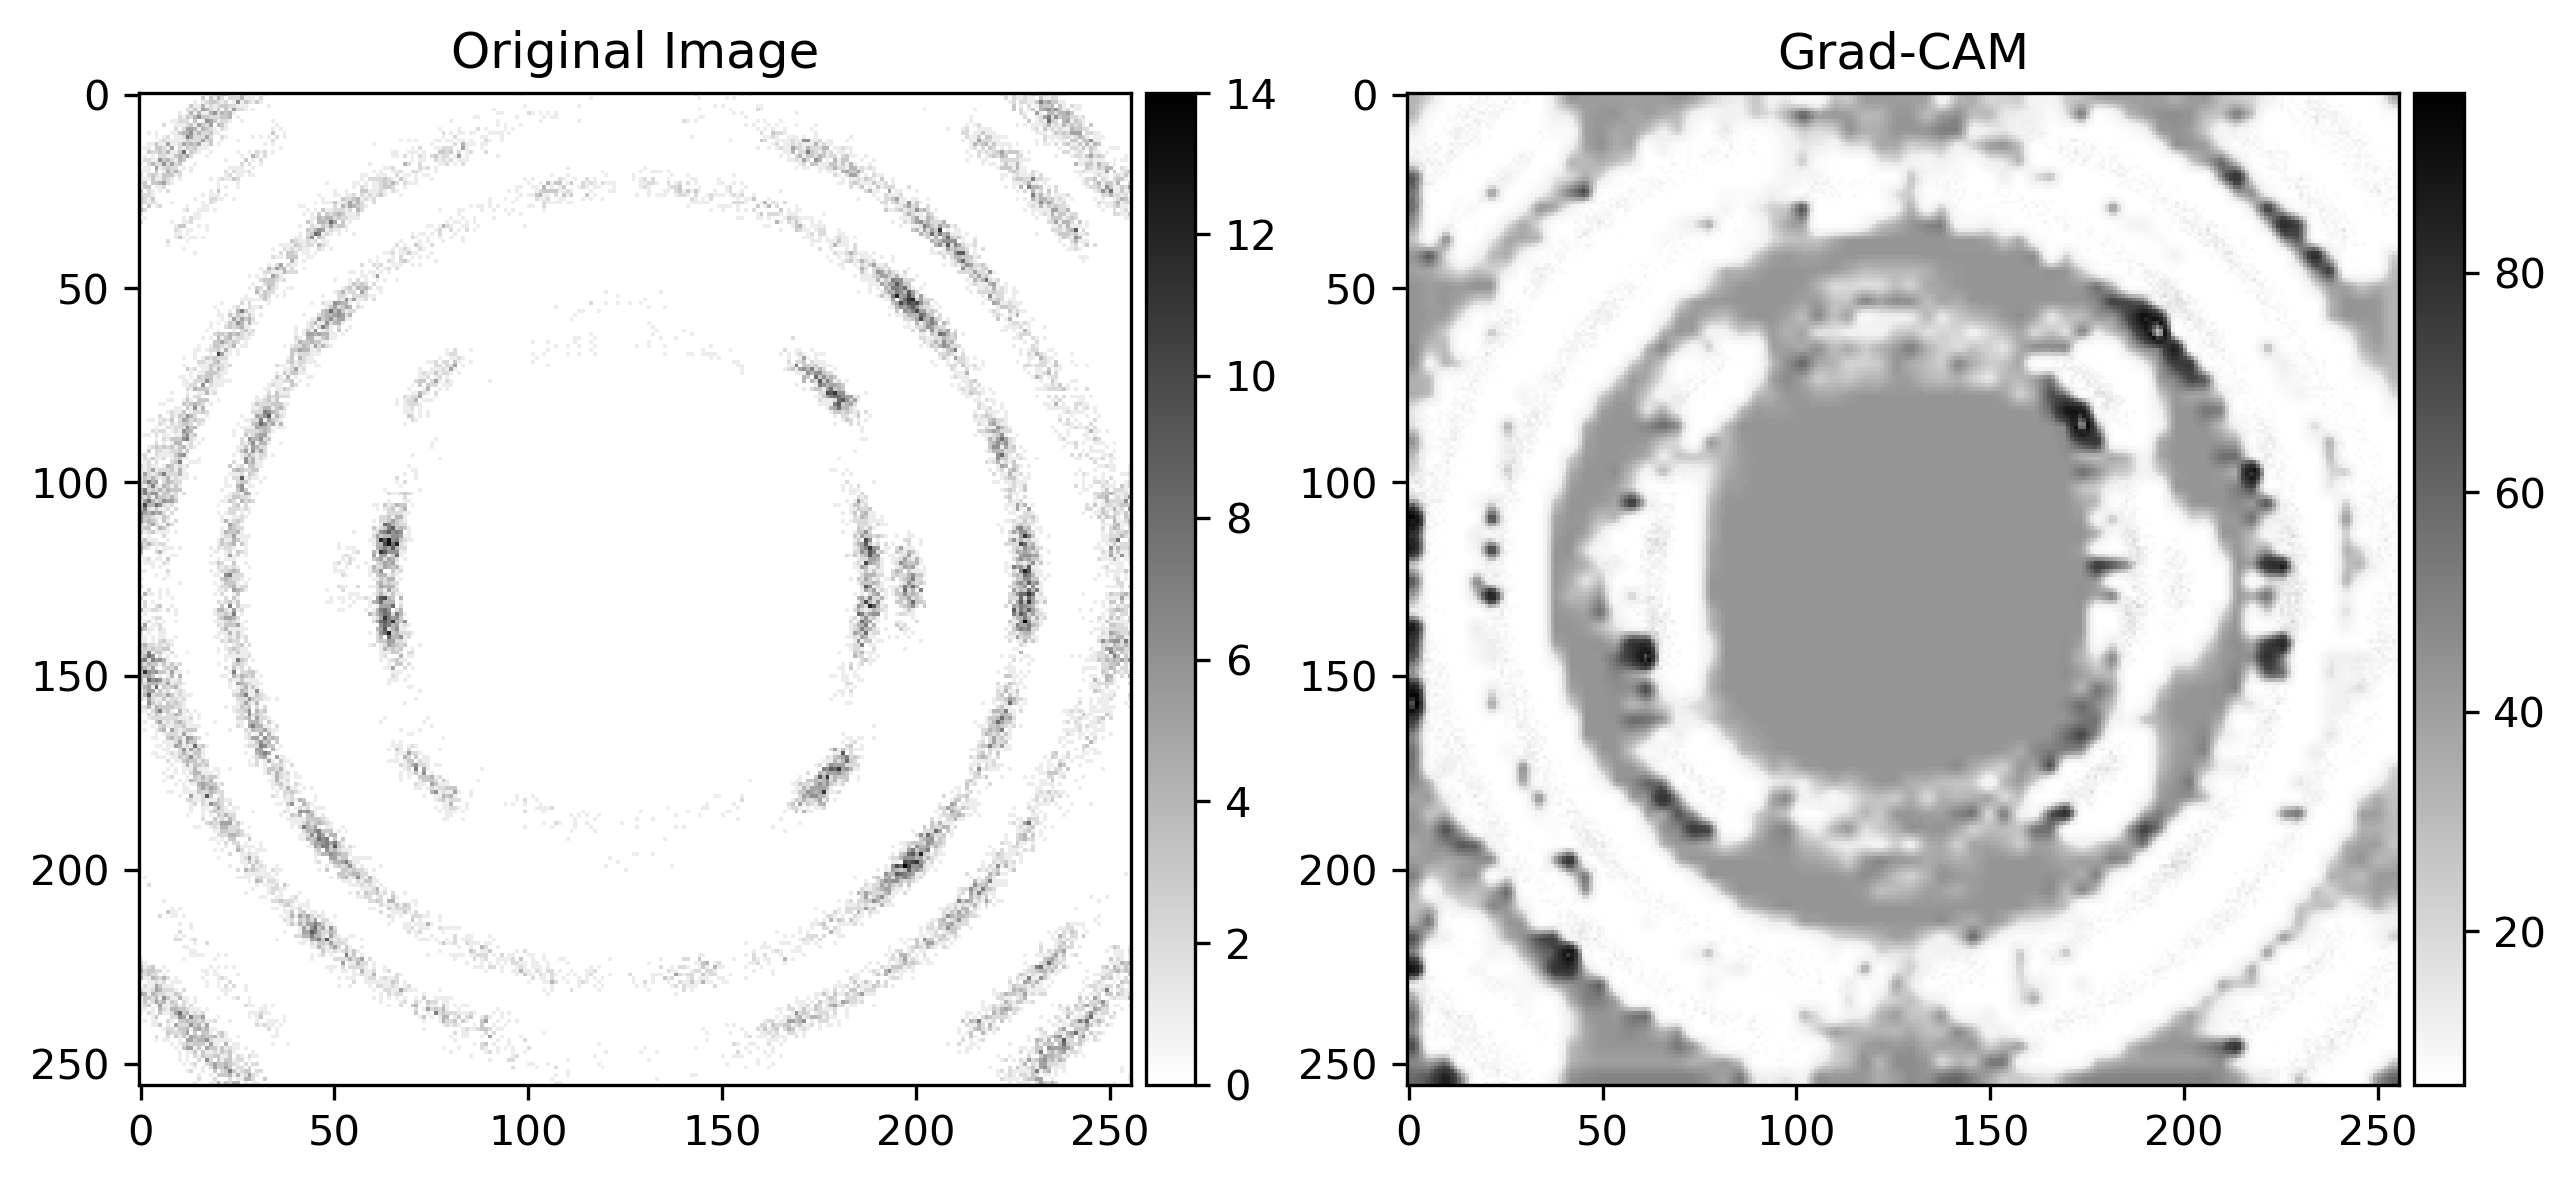


Epoch 5/9
----------
train Loss: 0.5337 Acc: 0.9600
val Loss: 0.5111 Acc: 0.9767


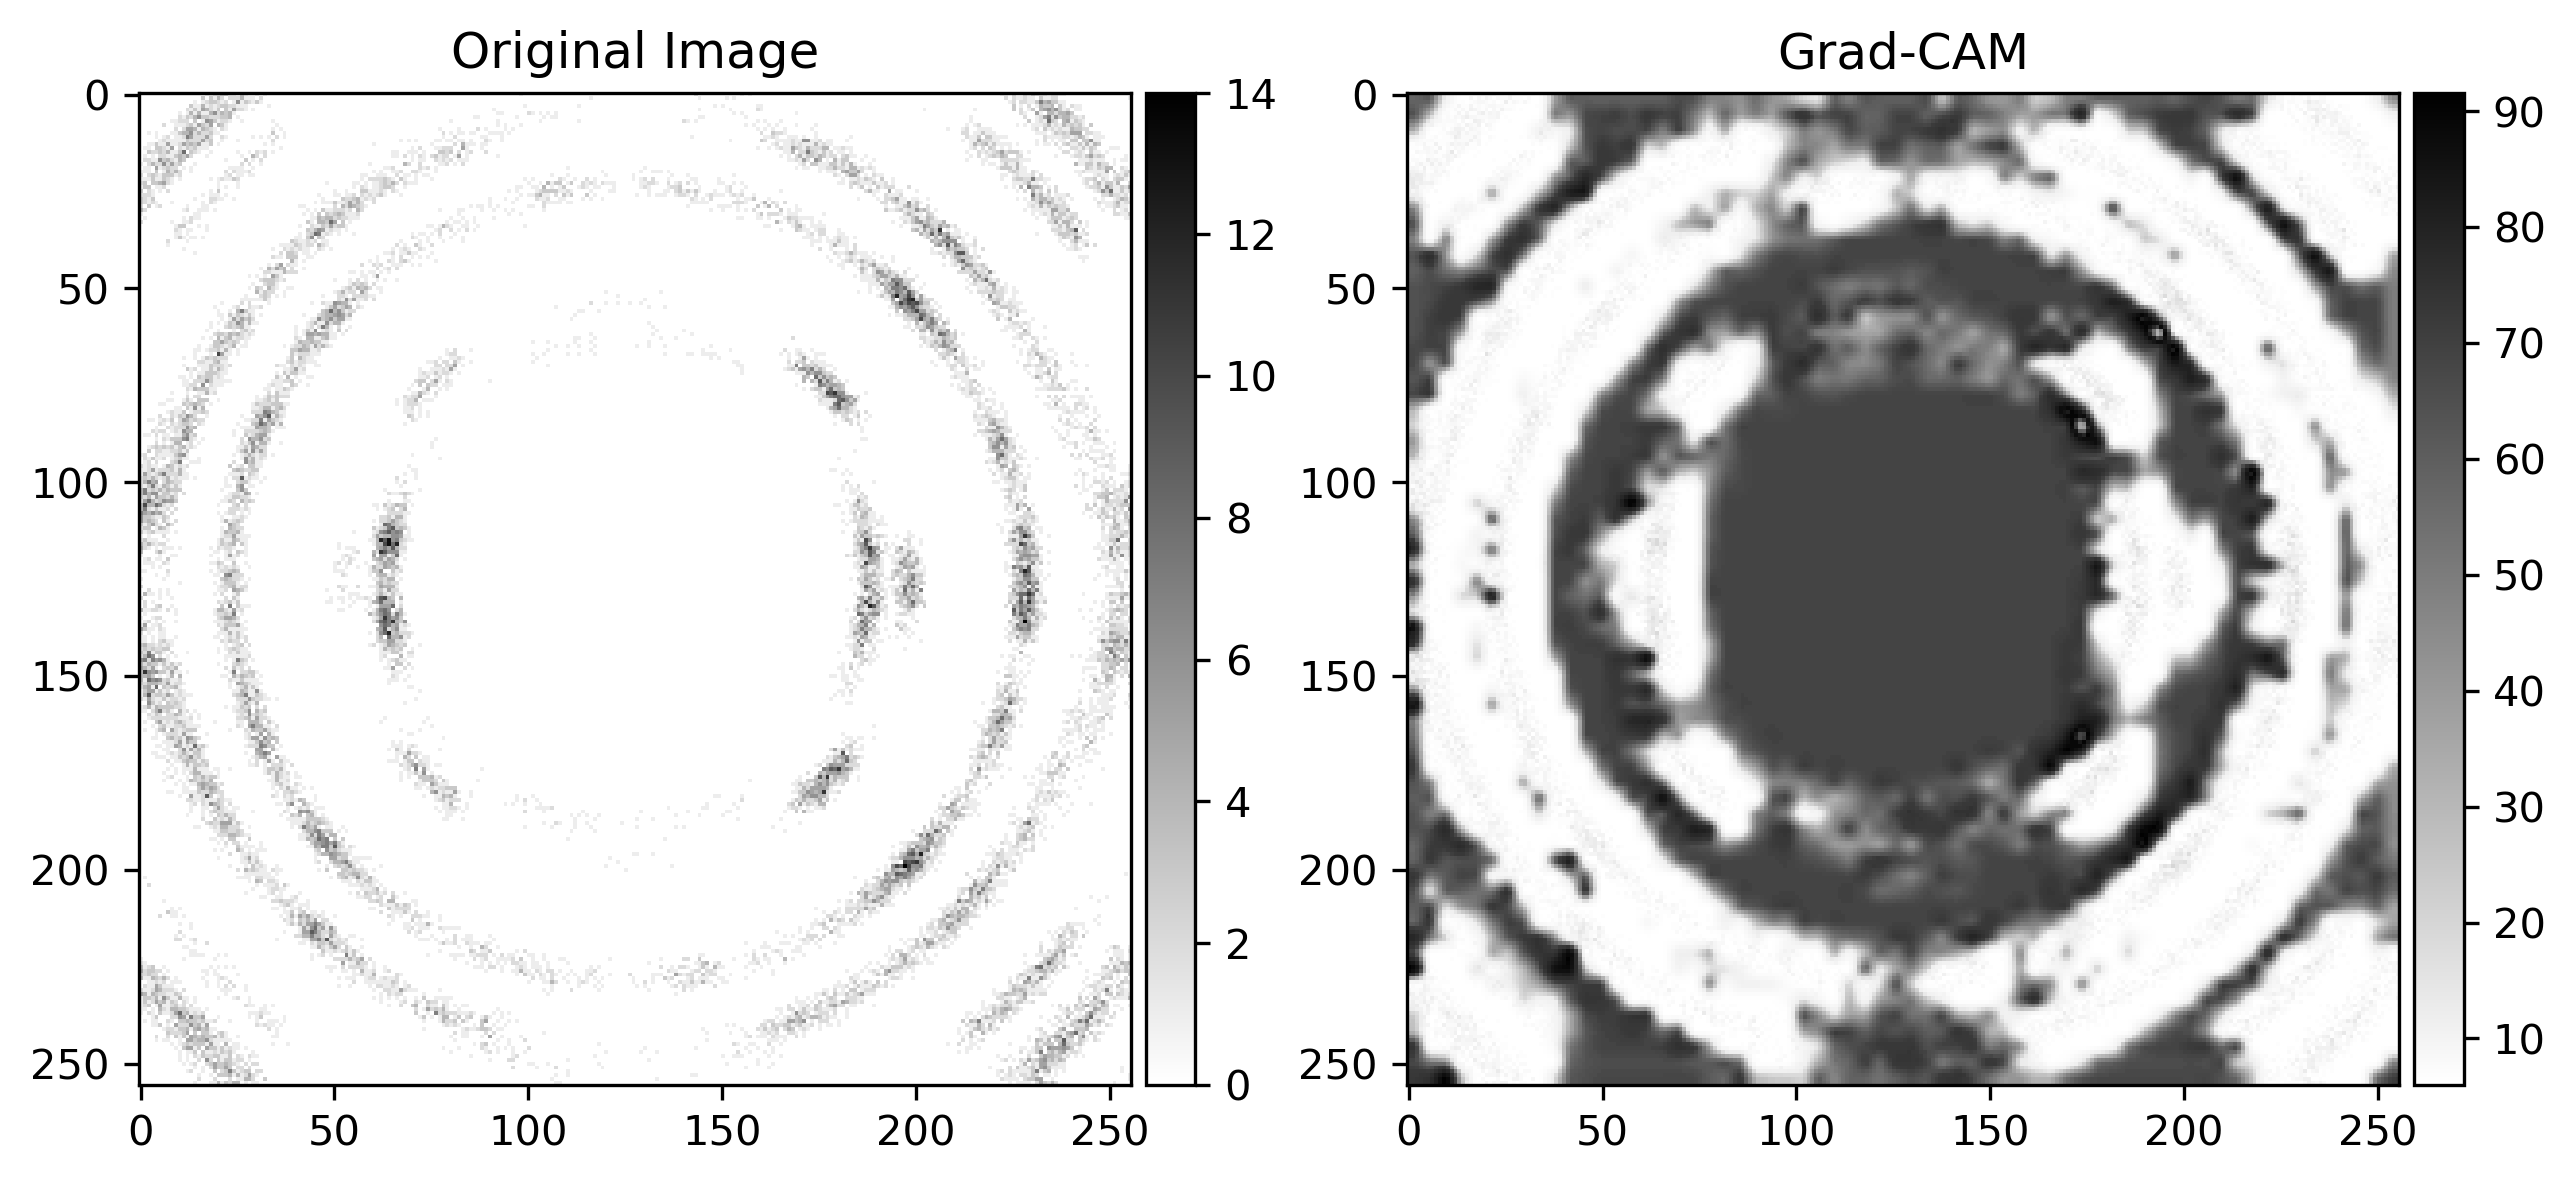


Epoch 6/9
----------
train Loss: 0.5163 Acc: 0.9700
val Loss: 0.4902 Acc: 0.9767


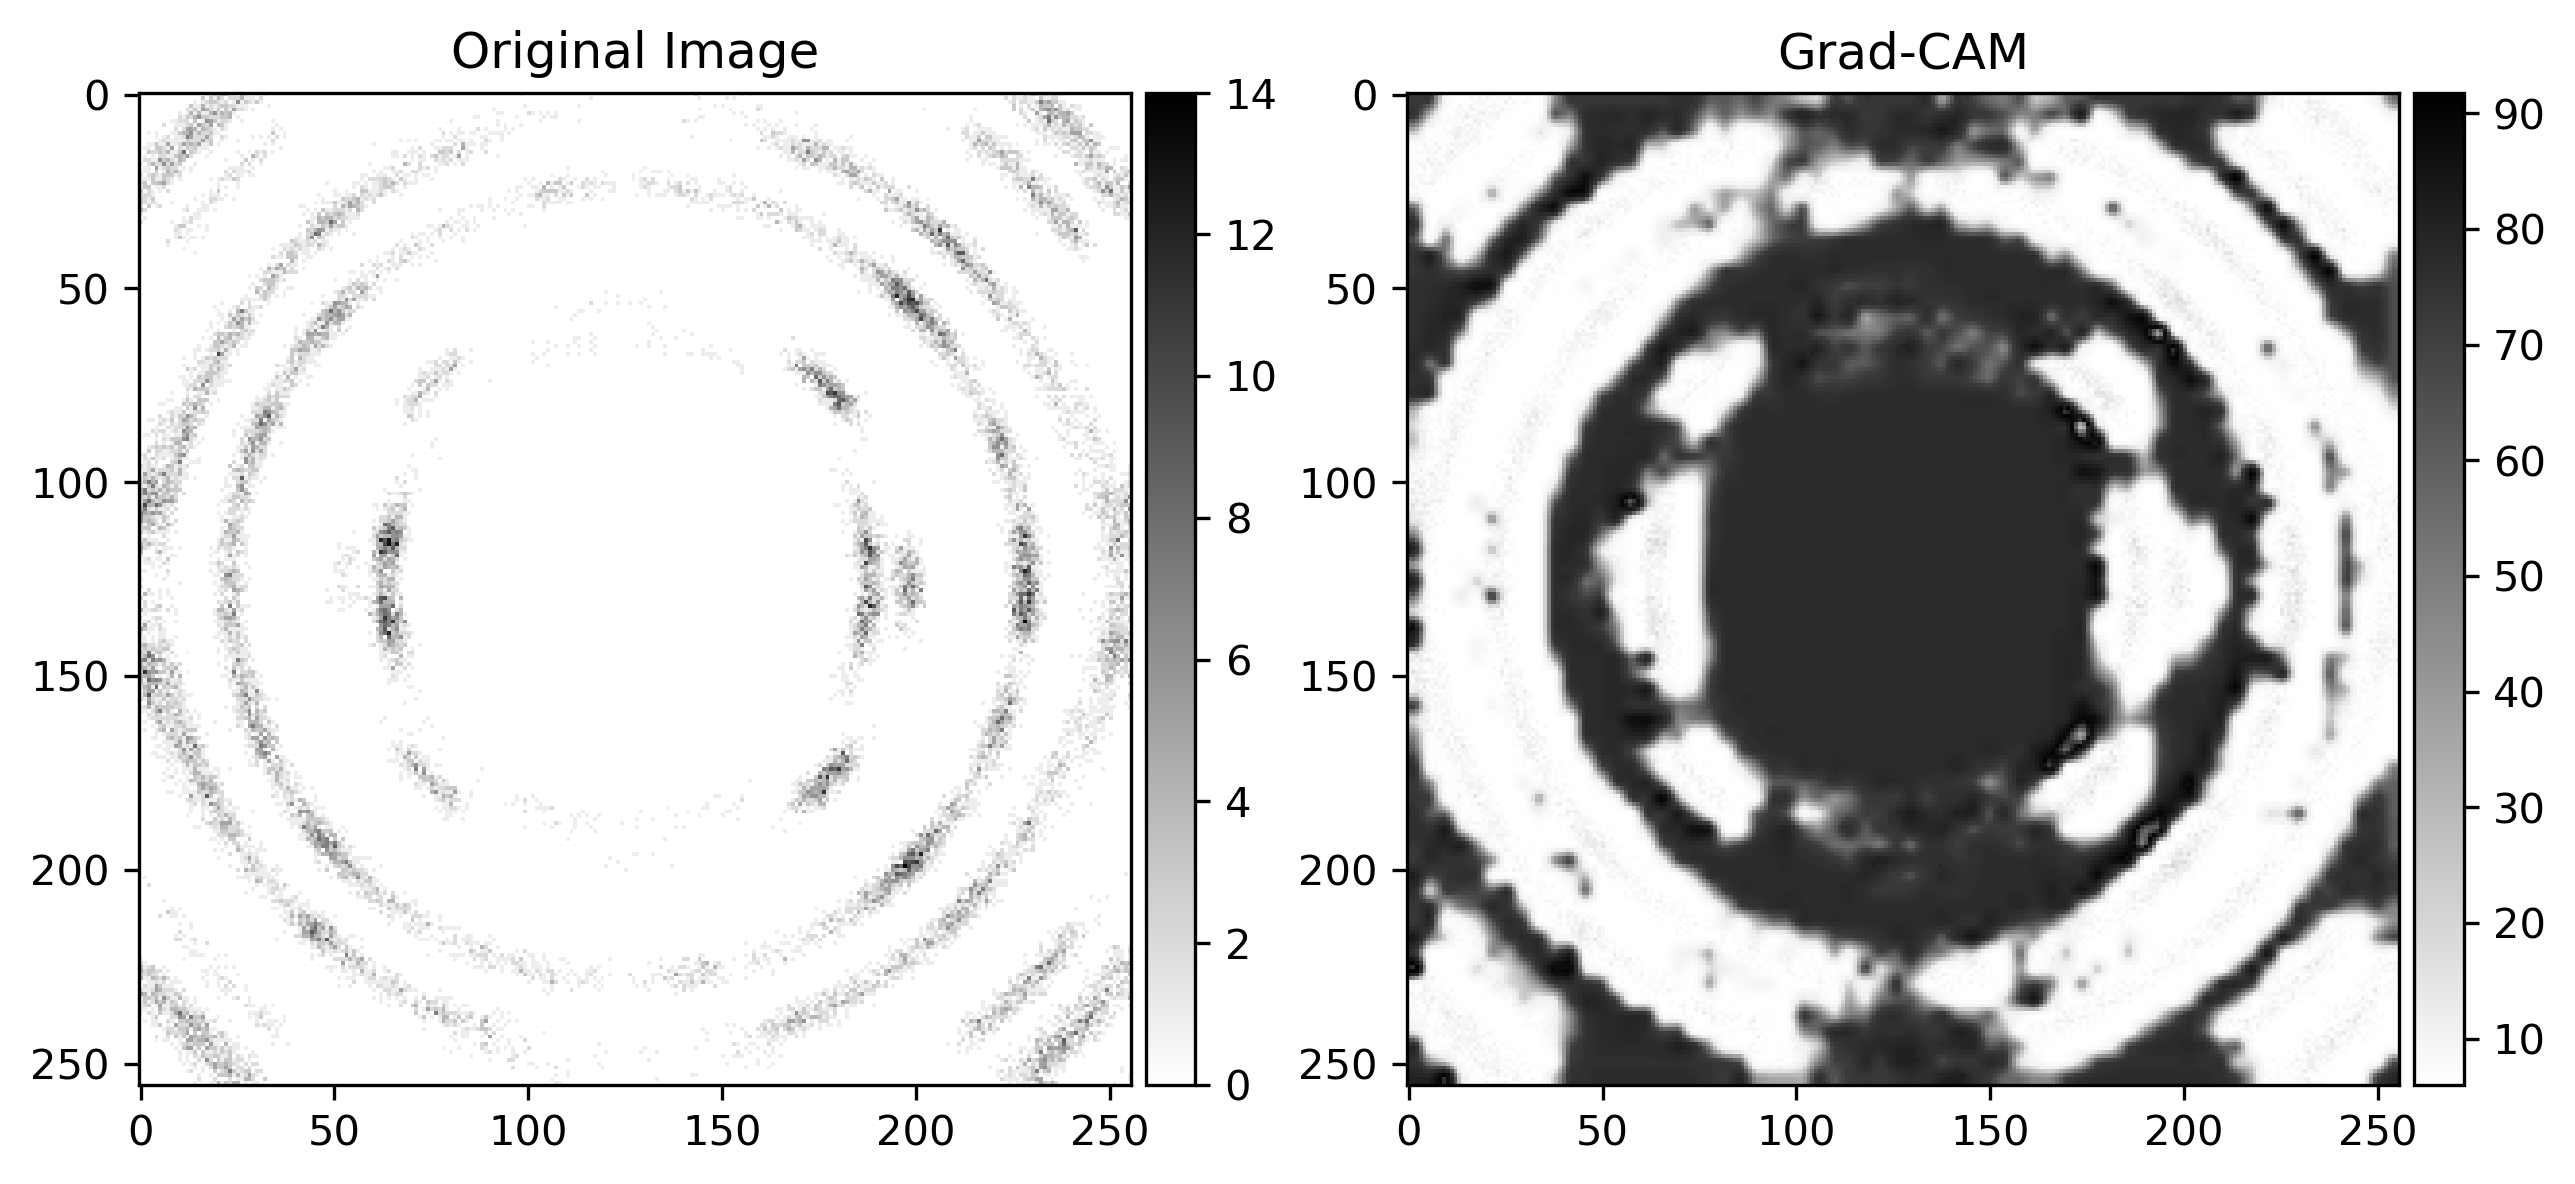


Epoch 7/9
----------
train Loss: 0.4858 Acc: 0.9900
val Loss: 0.4709 Acc: 0.9800


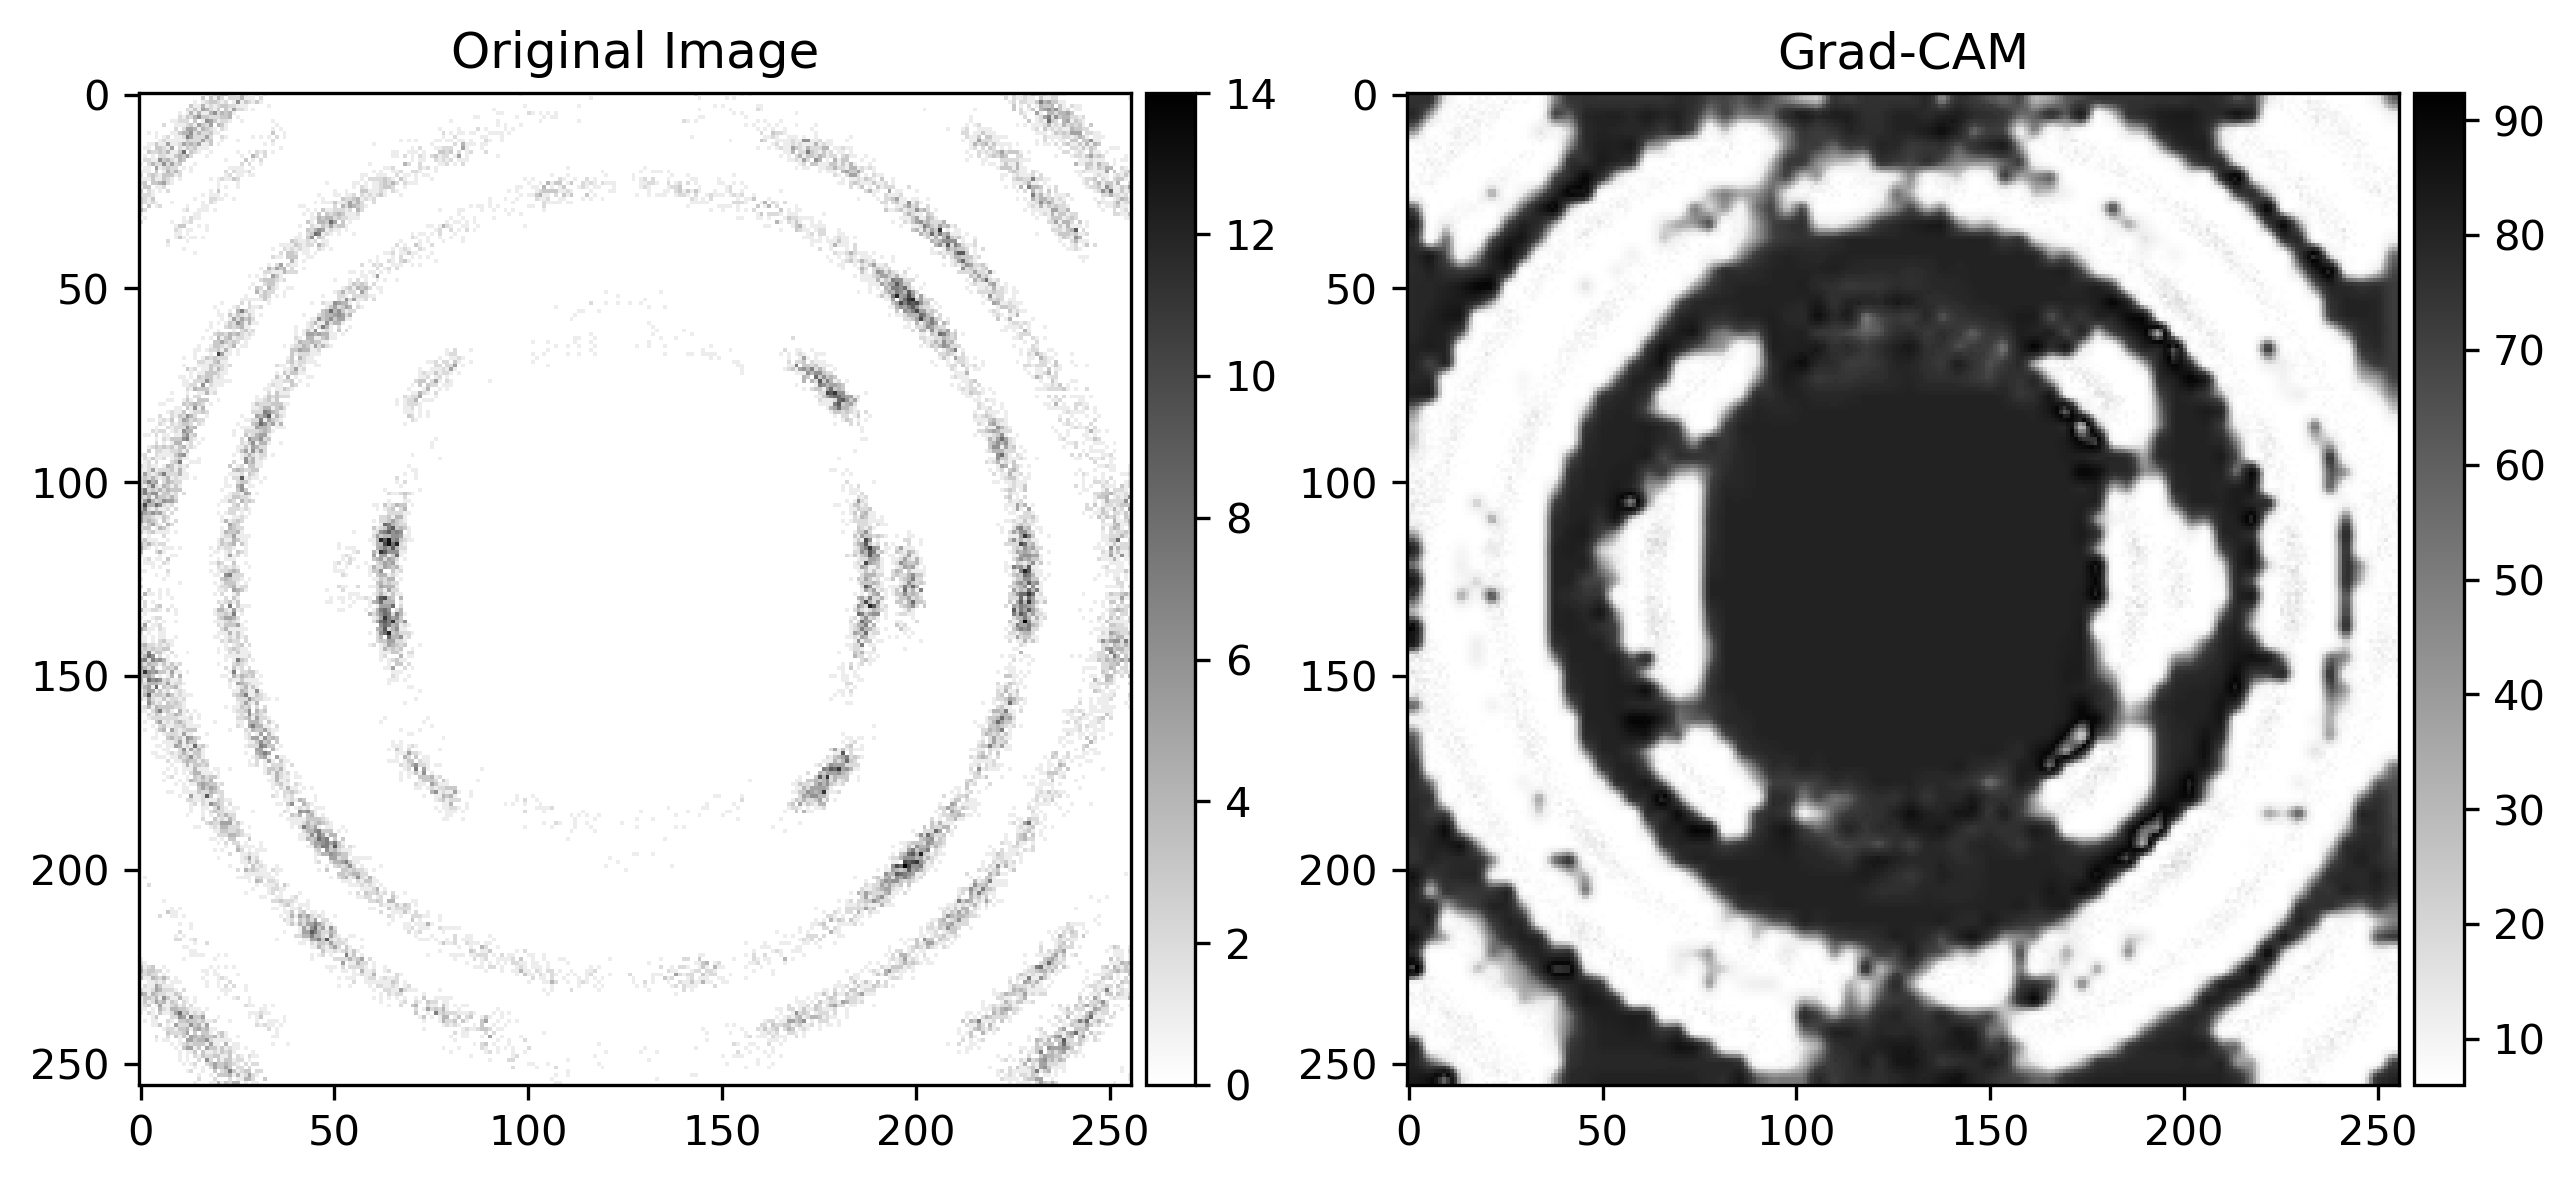


Epoch 8/9
----------
train Loss: 0.4741 Acc: 0.9700
val Loss: 0.4532 Acc: 0.9800


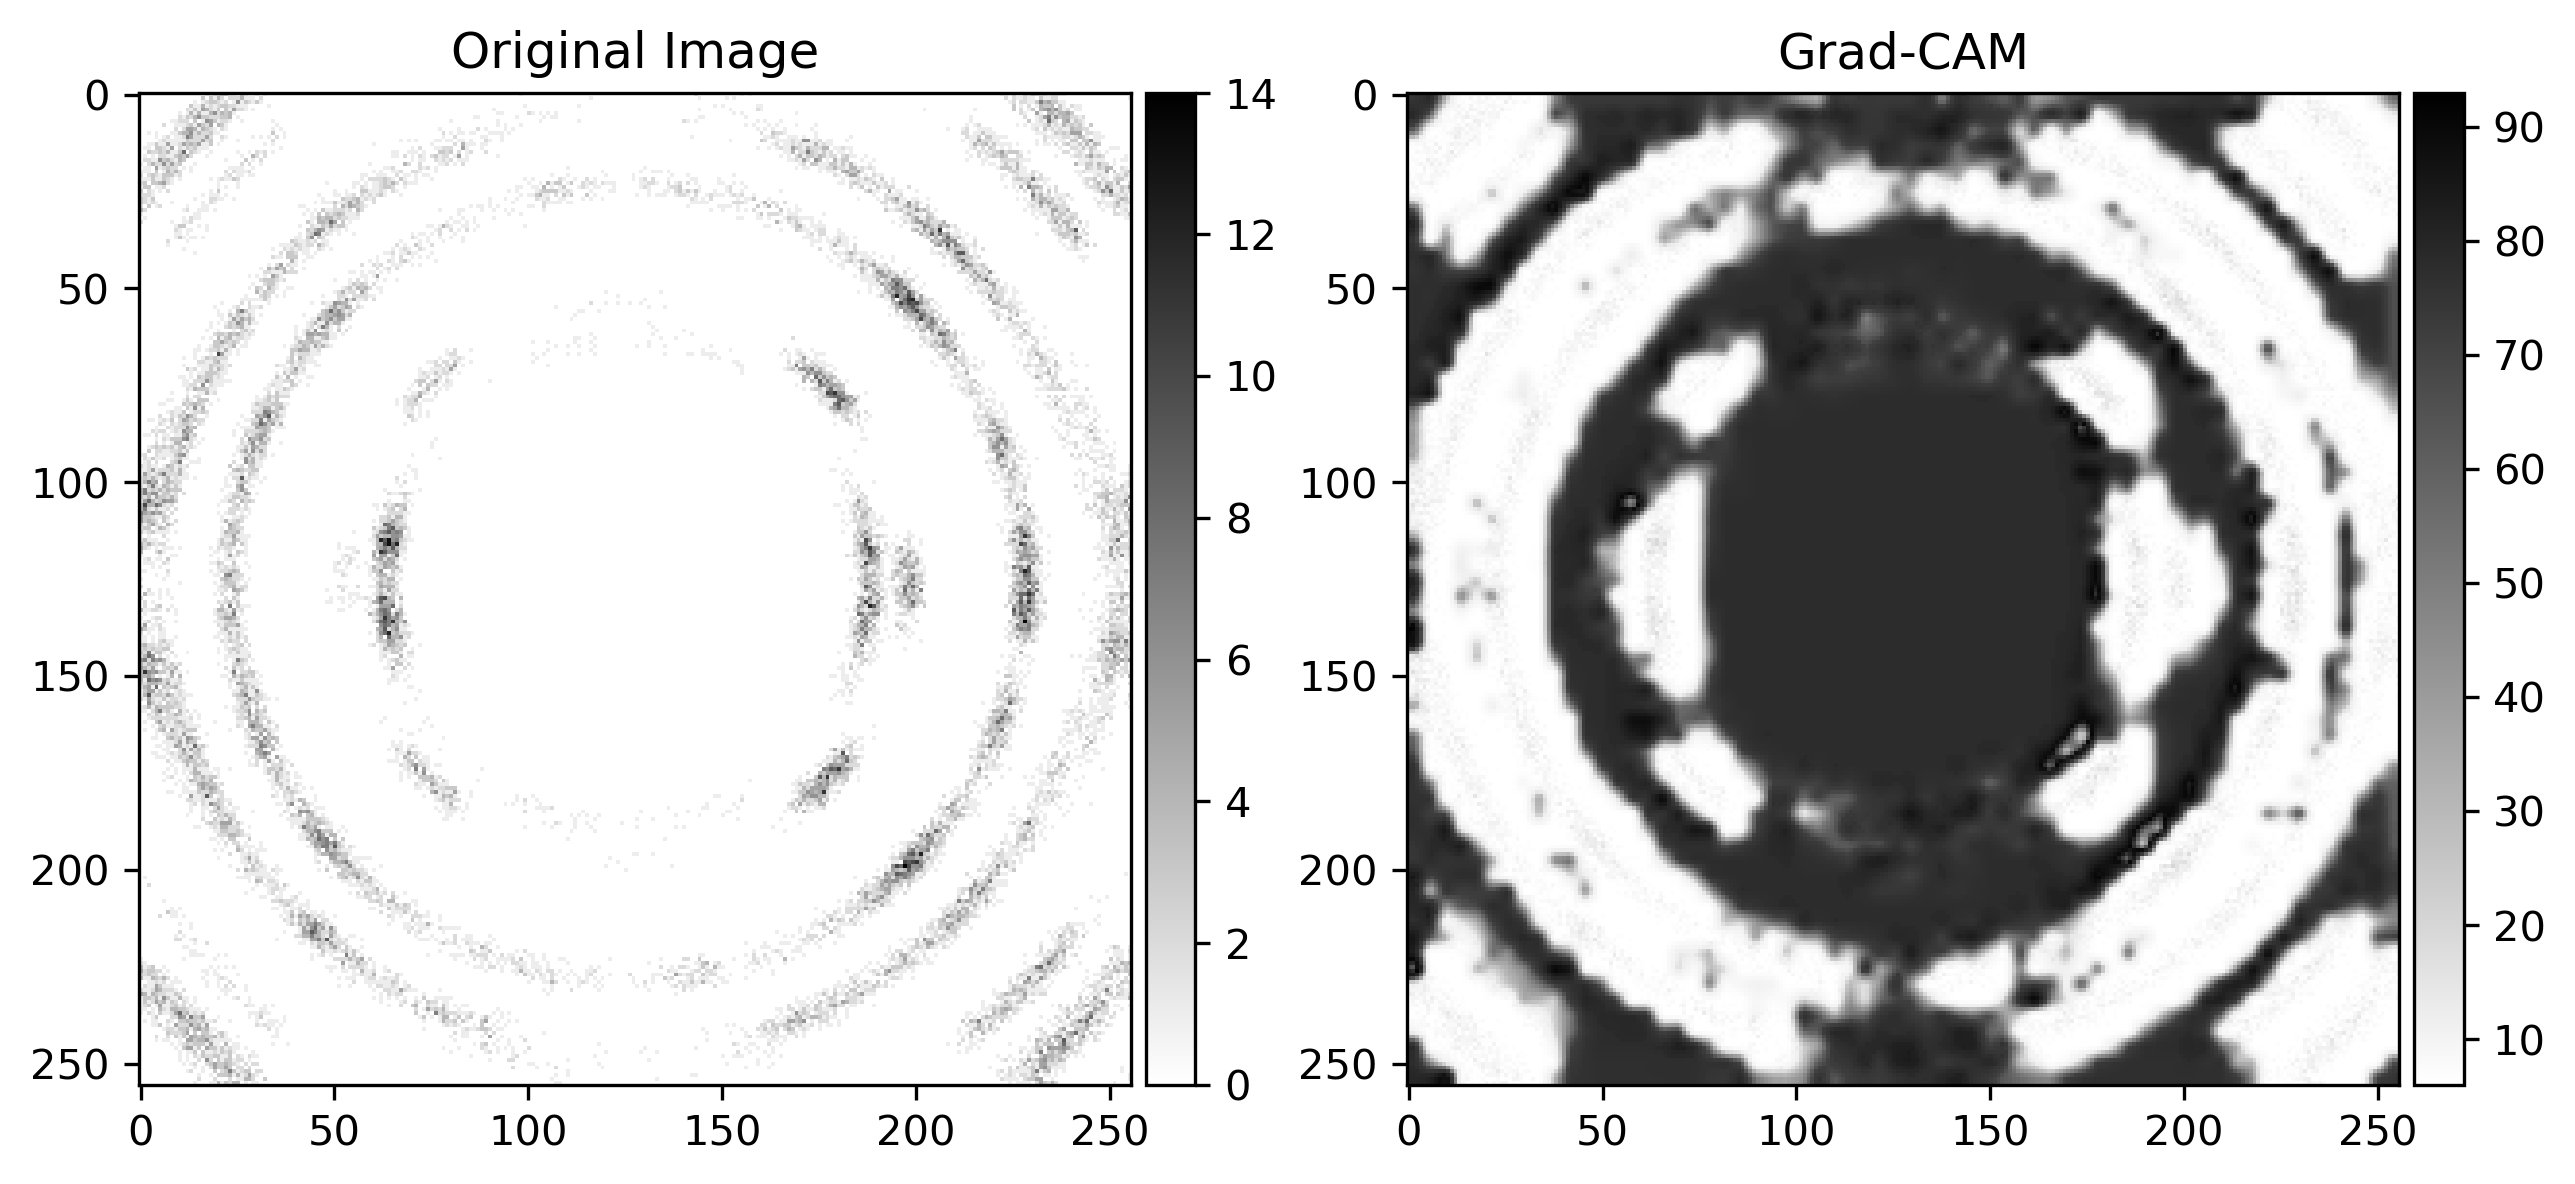


Epoch 9/9
----------
train Loss: 0.4597 Acc: 0.9800
val Loss: 0.4379 Acc: 0.9733


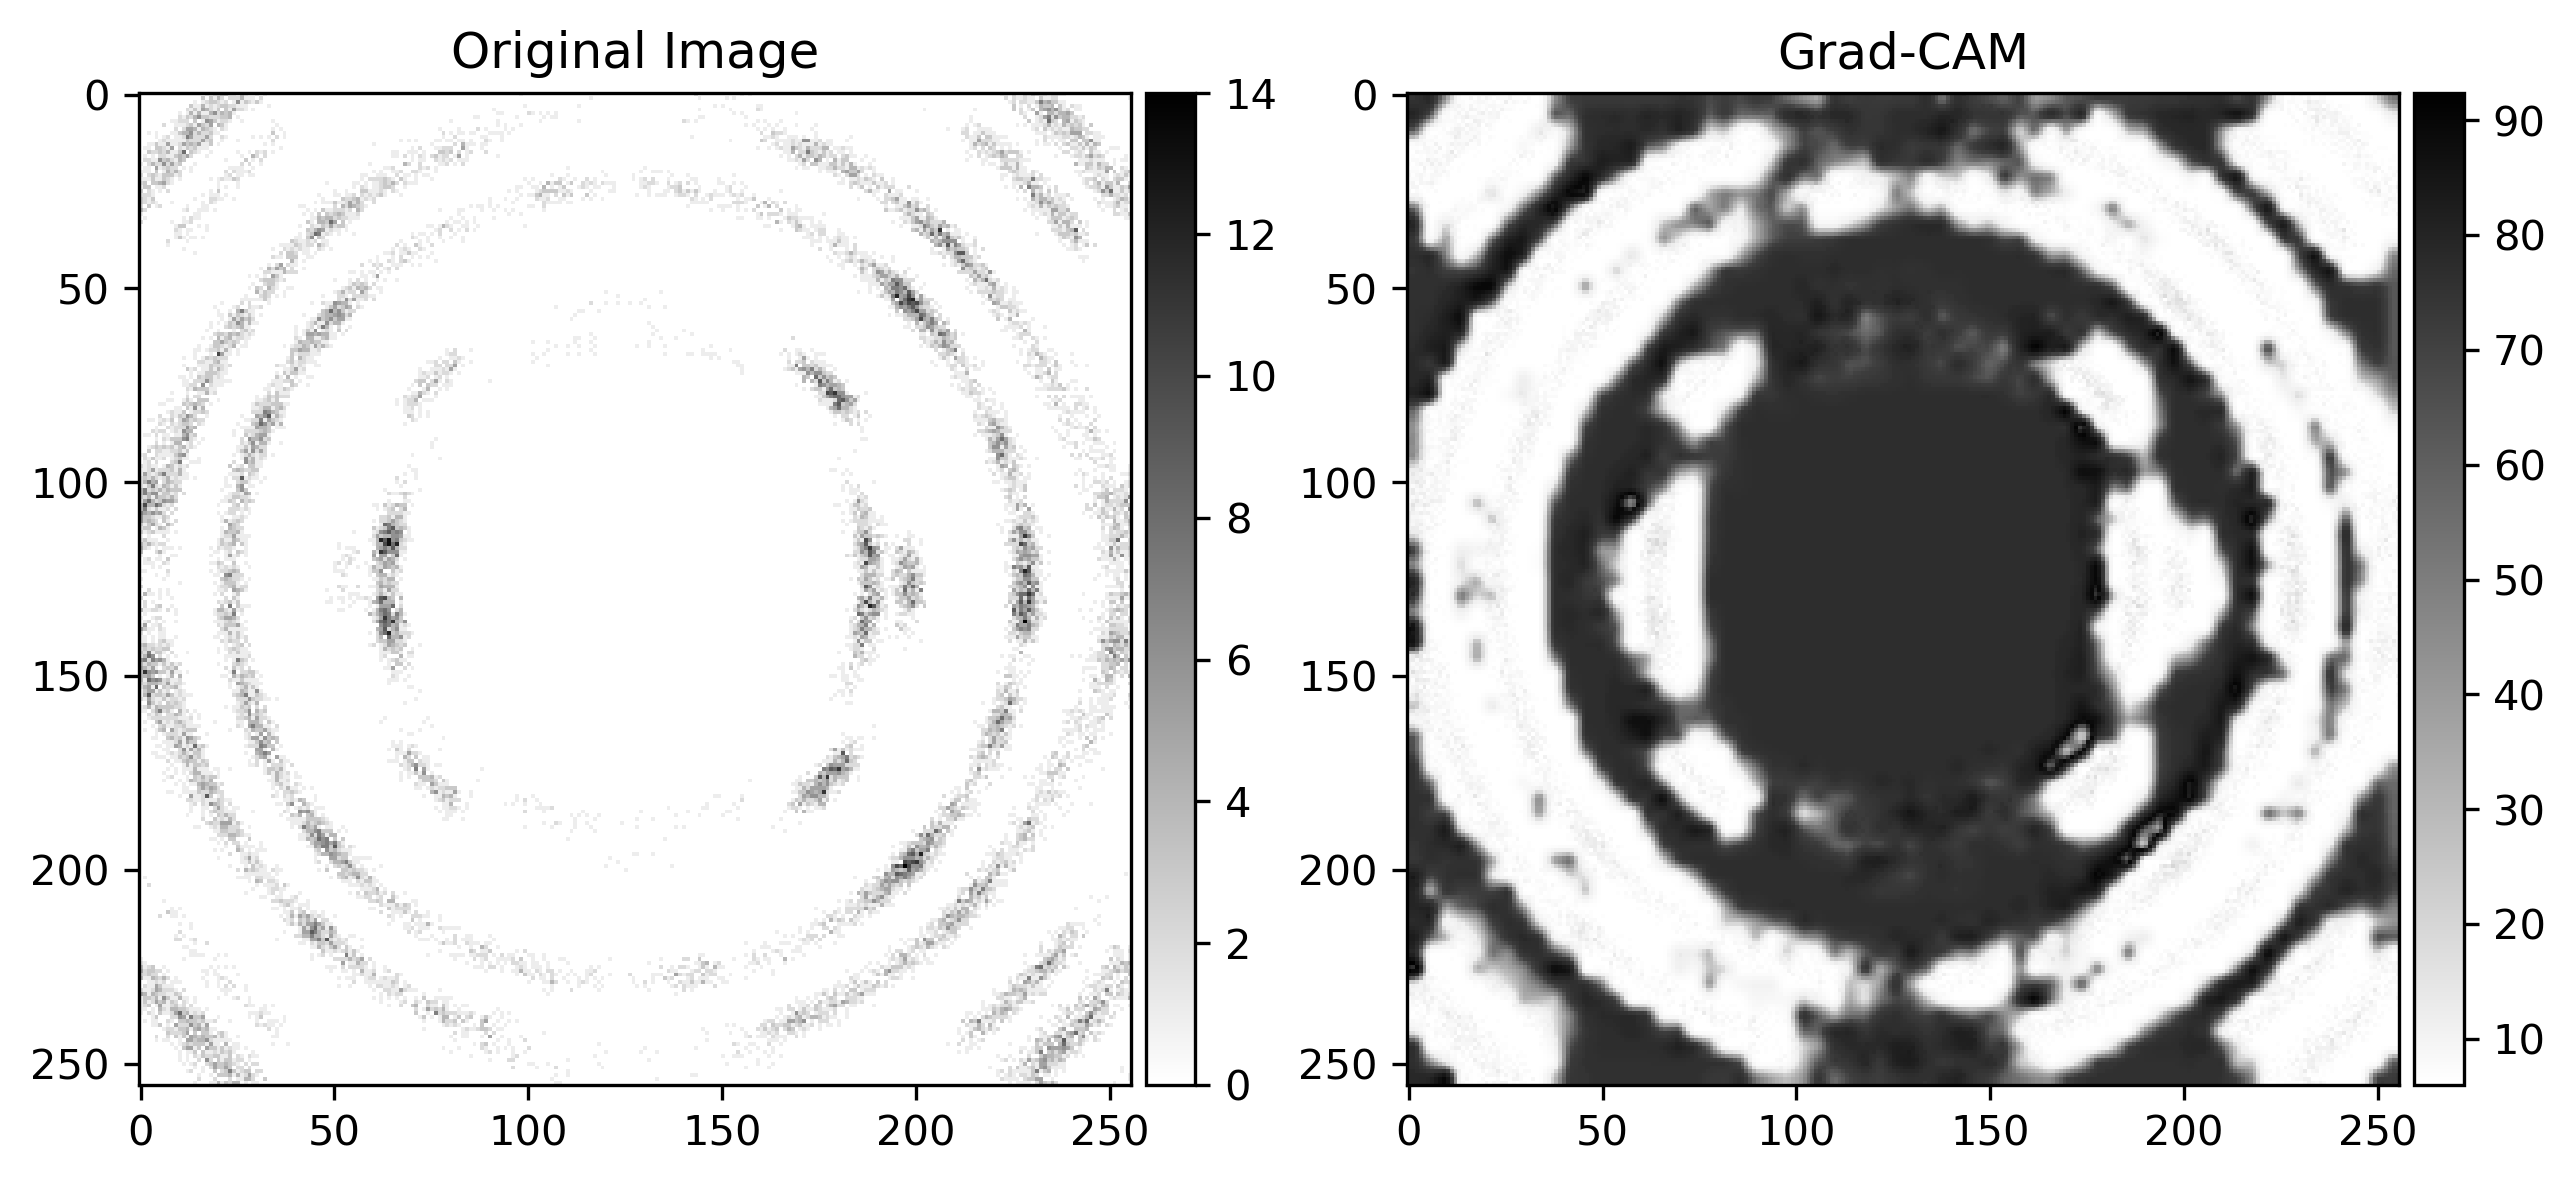

In [41]:
# Step 2: Update the Training Loop

def train_model(model, criterion, optimizer, dataloaders, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Generate and plot Grad-CAM for a random image from the validation set
        inputs, labels = next(iter(dataloaders['val']))
        input_image = inputs[0].unsqueeze(0)
        target_class = labels[0].item()
        generate_and_plot_gradcam(model, input_image, target_class)
        
        print()
    
    # Save the final model
    torch.save(model.state_dict(), '/gdrive/My Drive/NXSchool2024_MLDemo_Data/pxrd_net_final.pth')
    
    return model

# Assuming the dataloaders, criterion, optimizer, and device are defined as before
model = PXRDNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
model = train_model(model, criterion, optimizer, dataloaders, num_epochs=10)

### Summary

1. **Define the Grad-CAM Function**: This function generates and plots the Grad-CAM for a given input image and target class.
2. **Update the Training Loop**: Integrate the Grad-CAM generation and visualization into the training loop, specifically after each epoch using a random image from the validation set.
3. **Training and Visualization**: The model is trained while generating Grad-CAM visualizations at the end of each epoch to monitor which parts of the image the model is focusing on.

This setup provides a dynamic way to visually track the learning process of your model, enhancing interpretability and debugging capabilities.